# DS598 Final Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, make_scorer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
# import lightgbm as lgb
from pygam import LogisticGAM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Data Cleaning

In [3]:
Survival = pd.read_csv('dataset.csv')


In [4]:
Survival.shape

(91713, 85)

In [5]:
pd.set_option('display.max_columns', None)
Survival.head(20)
# pd.reset_option('display.max_columns')

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,92,admit,CTICU,0.541667,73.9,113.0,502.01,0,0.0,3.0,6.0,0.0,4.0,118.0,0.0,40.0,36.0,39.3,0.0,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,168.0,109.0,4.0,3.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,90,admit,Med-Surg ICU,0.927778,70.2,108.0,203.01,0,0.0,1.0,3.0,0.0,1.0,120.0,0.0,46.0,33.0,35.1,1.0,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,145.0,128.0,4.2,3.8,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,95.3,122.0,703.03,0,0.0,3.0,6.0,0.0,5.0,102.0,0.0,68.0,37.0,36.7,0.0,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,148.0,124.0,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room / Recovery,92,admit,CTICU,0.000694,61.7,203.0,1206.03,1,0.0,4.0,6.0,0.0,5.0,114.0,1.0,60.0,4.0,34.8,1.0,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,185.0,88.0,5.0,3.5,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,60.0,0.0,103.0,16.0,36.7,0.0,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,147.0,120.0,147.0,120.0,37.2,36.7,99.0,68.0,99.0,68.0,89.0,76.0,104.0,92.0,104.0,92.0,NaN,NaN,100.0,100.0,130.0,120.0,130.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0
5,33181,74489,83,67.0,27.560000,0,Caucasian,M,190.5,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,100.0,301.0,403.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,130.0,35.0,36.6,0.0,100.0,61.0,100.0,61.0,113.0,83.0,127.0,80.0,127.0,80.0,32.0,10.0,97.0,91.0,173.0,107.0,173.0,107.0,36.8,36.6,89.0,89.0,89.0,89.0,83.0,83.0,111.0,111.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,143.0,143.0,156.0,125.0,3.9,3.7,0

In [6]:
Survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [7]:
# remove column"Unnamed:83"
Survival.drop('Unnamed: 83', axis = 1, inplace = True)

In [8]:
# Calculate the proportion of NA
missing_percentage = (Survival.isnull().sum().sum() / (Survival.shape[0] * Survival.shape[1])) * 100

print("Percentage of missing values in the entire dataset: {:.2f}%".format(missing_percentage))
# dividing the total number of missing values by the total number of cells in the dataset

Percentage of missing values in the entire dataset: 2.55%


In [9]:
# Count the number of rows with NA values
rows_with_na = Survival[Survival.isnull().any(axis=1)].shape[0]

# Get the total number of rows
total_rows = Survival.shape[0]

# Calculate the percentage
percentage_rows_with_na = (rows_with_na / total_rows) * 100

print("Percentage of rows containing NA values in the total number of rows: {:.2f}%".format(percentage_rows_with_na))

Percentage of rows containing NA values in the total number of rows: 37.92%


#### Imputation of missing values

In [10]:
# Impute missing values with average value (Continious variables)
continuous_cols = ['age', 'bmi', 'pre_icu_los_days', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache',
                   'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache']

imputer = SimpleImputer(strategy='mean')

Survival_imputed = imputer.fit_transform(Survival[continuous_cols])

Survival[continuous_cols] = Survival_imputed

In [11]:
# Change class
categorical_cols = ['elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_post_operative', 
               'arf_apache','gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
                'diabetes_mellitus','hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
Survival[categorical_cols] = Survival[categorical_cols].astype('category')

# EDA

In [12]:
Survival['ethnicity'].unique()

['Caucasian', NaN, 'Hispanic', 'African American', 'Asian', 'Native American', 'Other/Unknown']
Categories (6, object): ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other/Unknown']

In [13]:
Survival['icu_admit_source'].unique()

['Floor', 'Accident & Emergency', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU', NaN]
Categories (5, object): ['Accident & Emergency', 'Floor', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU']

In [14]:
Survival['icu_stay_type'].unique()

['admit', 'readmit', 'transfer']
Categories (3, object): ['admit', 'readmit', 'transfer']

In [15]:
Survival['icu_type'].unique()

['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU', 'Cardiac ICU', 'CSICU']
Categories (8, object): ['CCU-CTICU', 'CSICU', 'CTICU', 'Cardiac ICU', 'MICU', 'Med-Surg ICU', 'Neuro ICU', 'SICU']

In [16]:
Survival['apache_2_bodysystem'].unique()

array(['Cardiovascular', 'Respiratory', 'Metabolic', 'Trauma',
       'Neurologic', 'Gastrointestinal', 'Renal/Genitourinary', nan,
       'Undefined diagnoses', 'Haematologic', 'Undefined Diagnoses'],
      dtype=object)

In [17]:
Survival.describe()

,encounter_id,patient_id,hospital_id,age,bmi,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
count,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,88094.000000,88094.000000,84363.000000,84363.000000,88923.000000,88923.000000,87074.000000,87074.000000,82629.000000,82629.000000,87356.000000,87356.000000,87528.000000,87528.000000,88102.000000,88102.000000,84372.000000,84372.000000,85906.000000,85906.000000,82128.000000,82128.000000,83766.000000,83766.000000,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,169.641588,508.357692,0.835766,84.028340,185.401739,558.216377,3.465049,5.471195,3.994778,99.707932,88.015873,25.811007,36.414472,88.491873,50.161314,88.610513,50.242597,103.000568,70.321848,104.651339,64.871859,104.590454,64.941541,28.882774,12.846279,99.241836,90.454826,148.339745,96.92387,148.235549,96.993313,37.284201,36.268391,75.354508,62.838150,75.805934,63.270616,92.229198,83.663720,91.612950,79.400028,91.594126,79.709315,22.633614,17.211525,98.044637,95.174310,133.247395,116.362296,133.054686,116.549625,174.638023,114.380940,4.251594,3.934658,0.086787,0.043955,0.086302
std,37795.088538,37811.252183,62.854406,16.383883,8.118970,10.795378,228.989661,2.487756,25.011497,85.267612,460.477835,0.941800,1.274954,1.543912,30.722378,41.804012,15.004339,0.814615,19.798379,13.317586,19.793743,13.341521,22.017346,17.115903,20.808358,15.679680,20.701171,15.701305,10.701973,5.064943,1.794181,10.030069,25.733259,20.67793,25.792453,20.705016,0.693287,0.745147,18.409190,16.363229,18.481826,16.422063,21.823704,20.279869,20.533174,19.130590,20.552018,19.236507,7.515043,6.072588,3.212934,6.625227,27.556986,26.510637,27.679751,26.623528,86.687955,38.273013,0.667355,0.579610,0.247569,0.217341,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,137.200000,82.000000,-24.947222,38.600000,101.000000,0.010000,1.000000,1.000000,1.000000,30.000000,40.000000,4.000000,32.100000,46.000000,13.000000,46.000000,13.000000,58.000000,0.000000,60.000000,22.000000,60.000000,22.000000,14.000000,0.000000,0.000000,0.000000,90.000000,41.00000,90.000000,41.030000,35.100000,31.889000,37.000000,22.000000,37.000000,22.000000,46.000000,36.000000,49.000000,32.000000,49.000000,32.000000,10.000000,0.000000,0.000000,0.000000,75.000000,53.000000,75.000000,53.000000,73.000000,33.000000,2.800000,2.400000,-1.000000,-1.000000,0.000000
25%,32852.000000,32830.000000,47.000000,53.000000,23.787760,162.500000,369.000000,0.035417,66.800000,113.000000,203.010000,3.000000,6.000000,3.994778,87.000000,54.000000,11.000000,36.200000,75.000000,42.000000,75.000000,42.000000,87.000000,60.000000,90.000000,55.000000,90.

In [18]:
# Outcome variable
Survival.hospital_death.value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [19]:
(83798 + 7915) / 7915

11.587239418825016

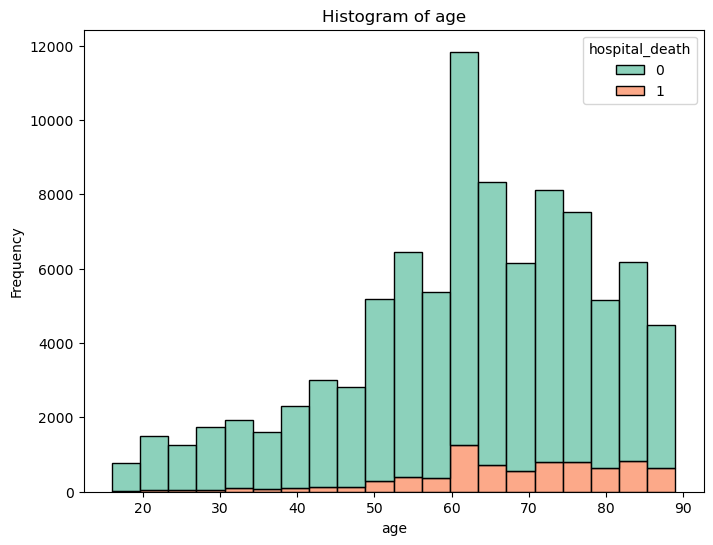

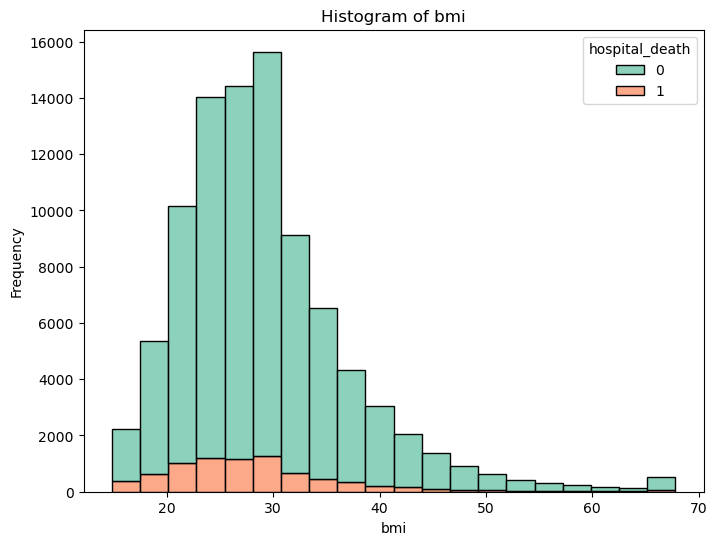

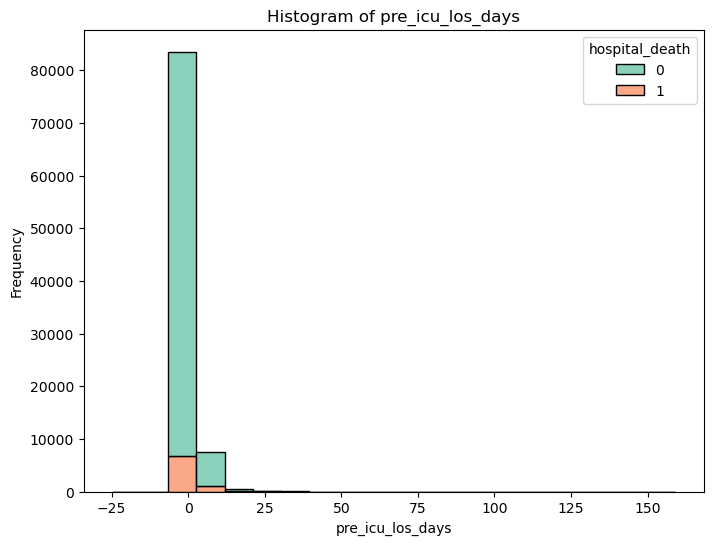

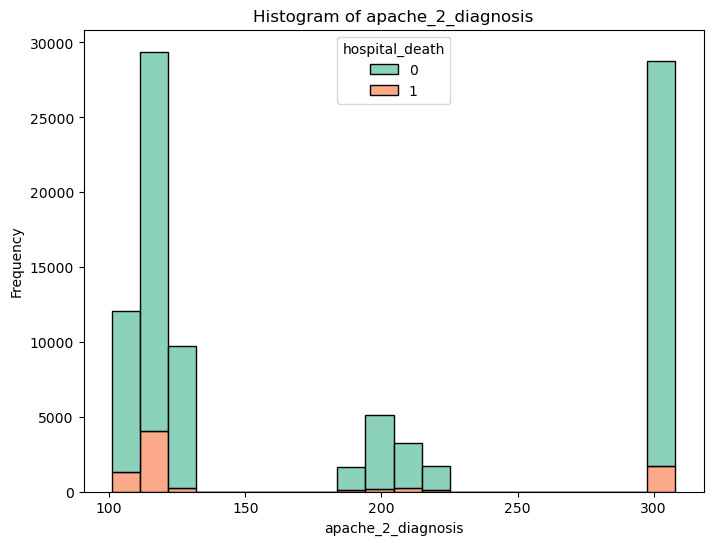

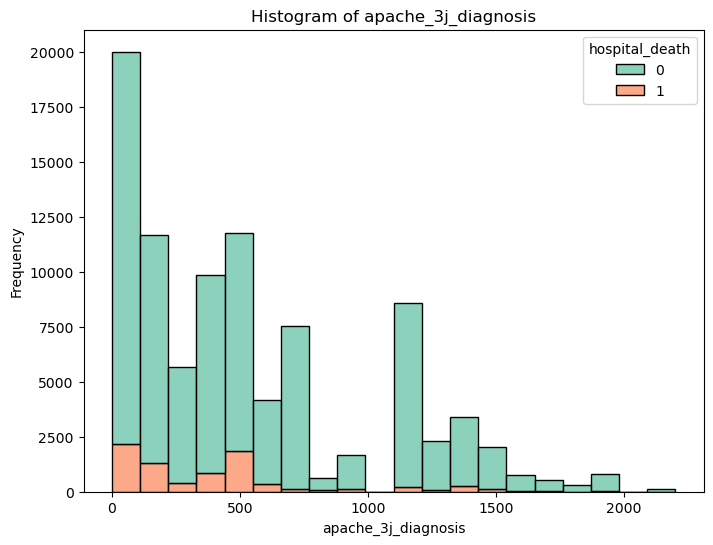

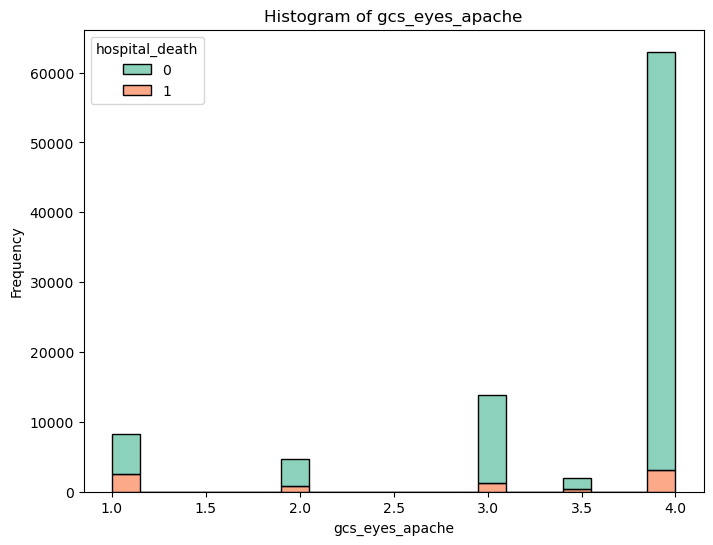

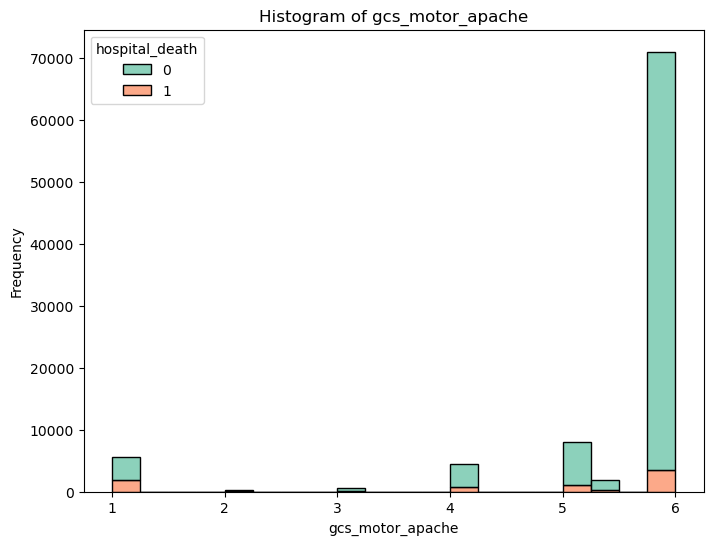

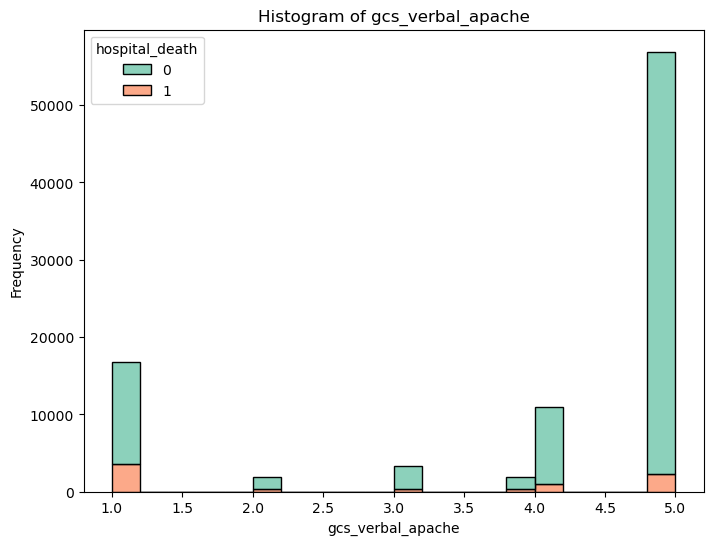

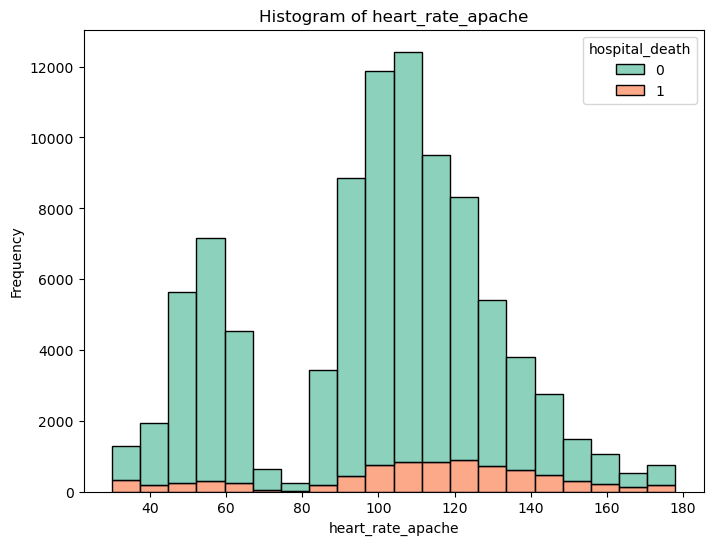

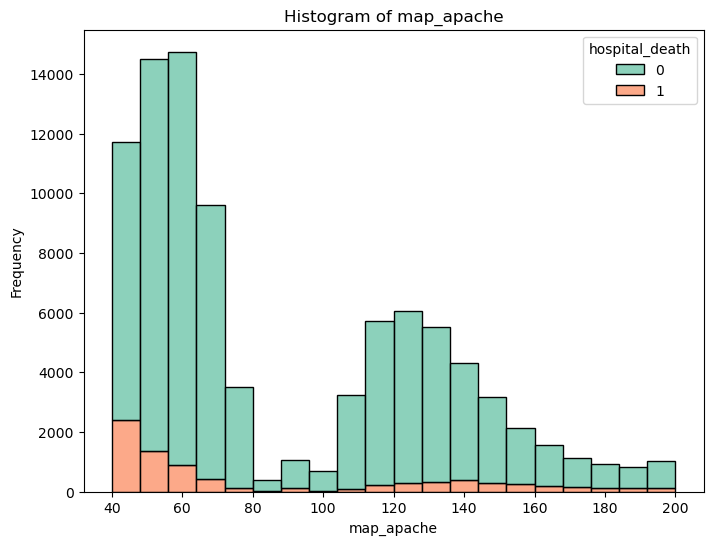

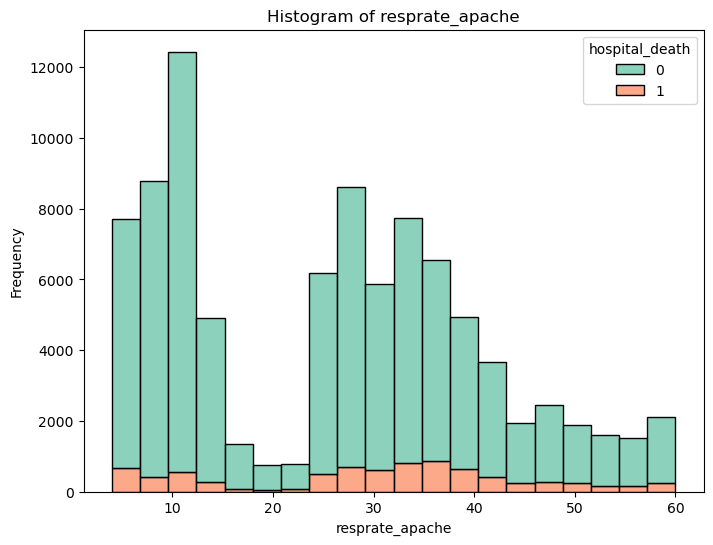

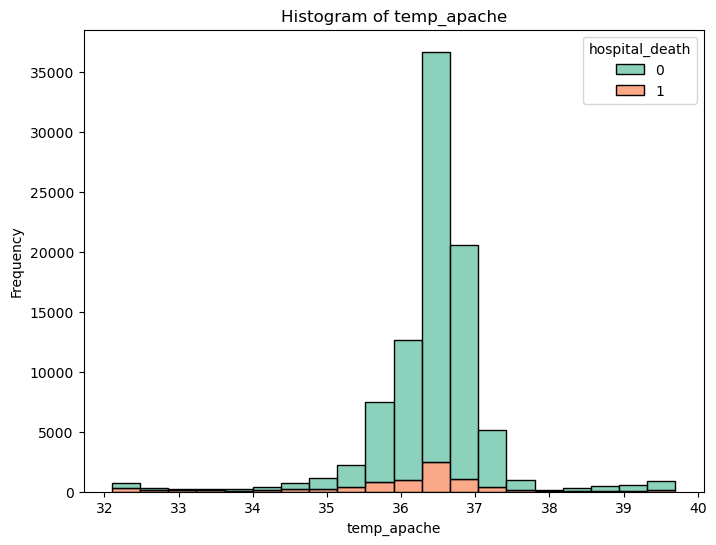

In [20]:
# check distributions of interested continuousu variable
# Create a list of variables to plot
var_cont = ['age', 'bmi', 'pre_icu_los_days', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache',
            'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache']  

# Plot histograms for each variable
for var in var_cont:
    plt.figure(figsize=(8, 6))  # Set the size of the plot area
    sns.histplot(data=Survival, x=var, bins=20, hue='hospital_death', multiple='stack', palette='Set2')  # Plot the histogram with color differentiation
    plt.title('Histogram of {}'.format(var))  # Set the title
    plt.xlabel(var)  # Set the x-axis label
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.show()  # Show the histogram


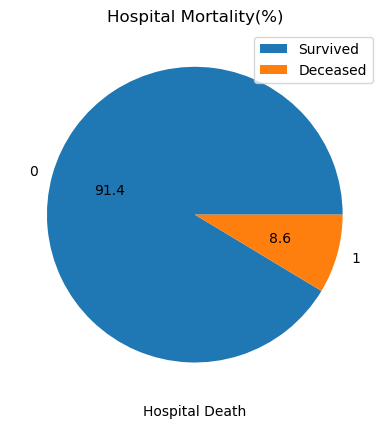

In [21]:
Survival.hospital_death.value_counts().plot(kind='pie', autopct="%.1f", title='Hospital Mortality(%)')
# Add labels
plt.ylabel('')  # Remove y-axis label
plt.xlabel('Hospital Death')  # Add x-axis label
plt.legend(labels=['Survived', 'Deceased'], loc='upper right')  

plt.show()

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


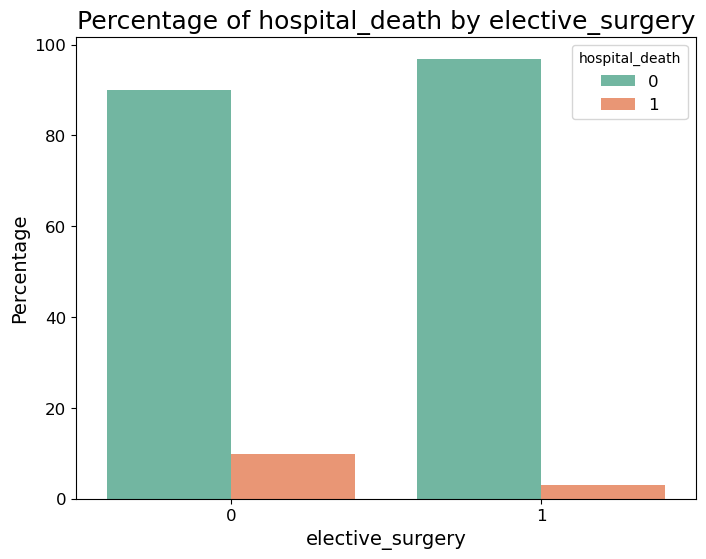

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


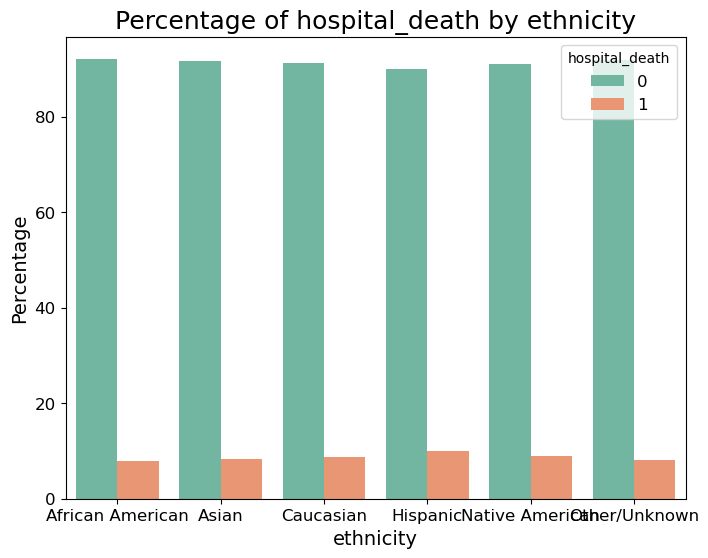

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


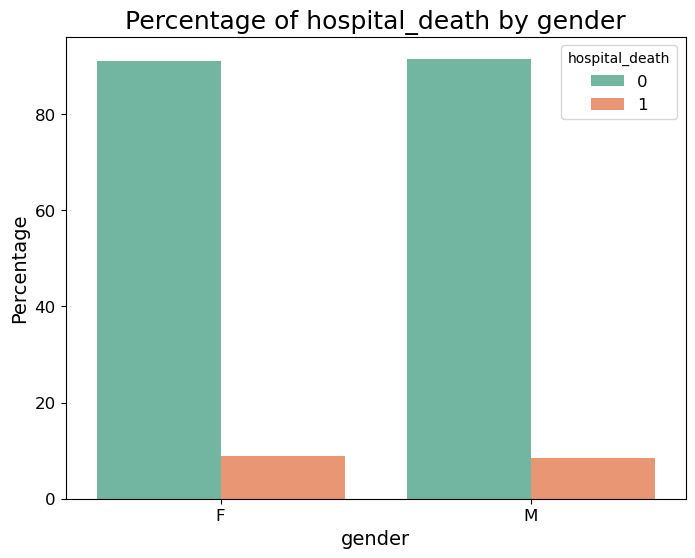

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


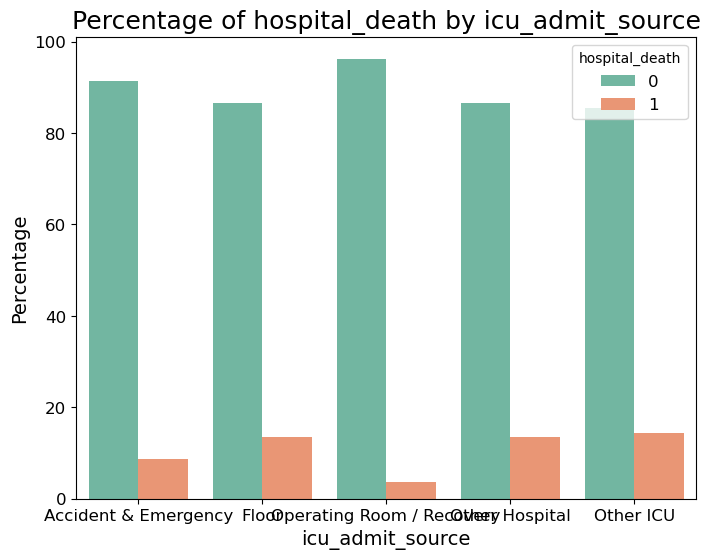

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


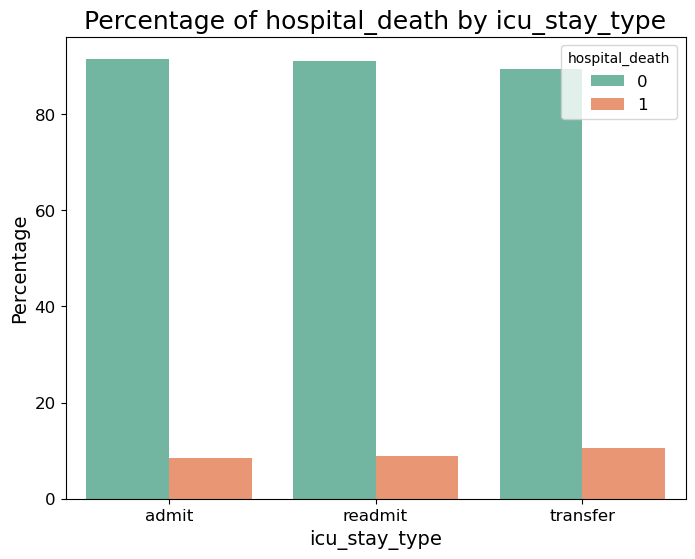

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


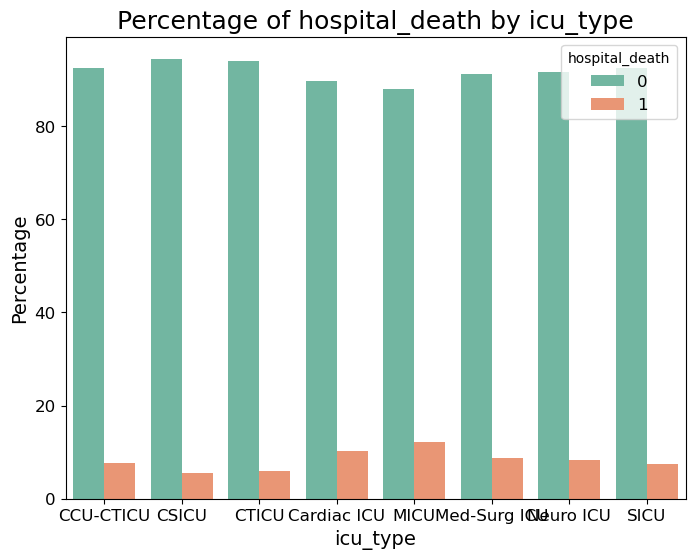

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


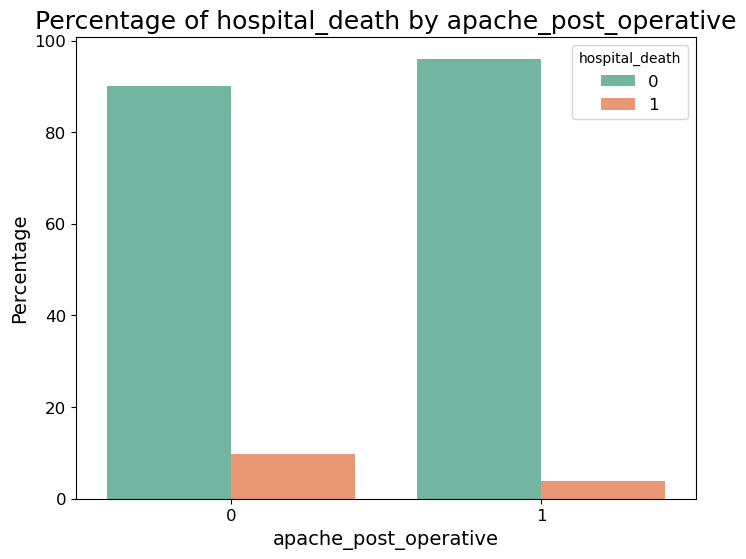

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


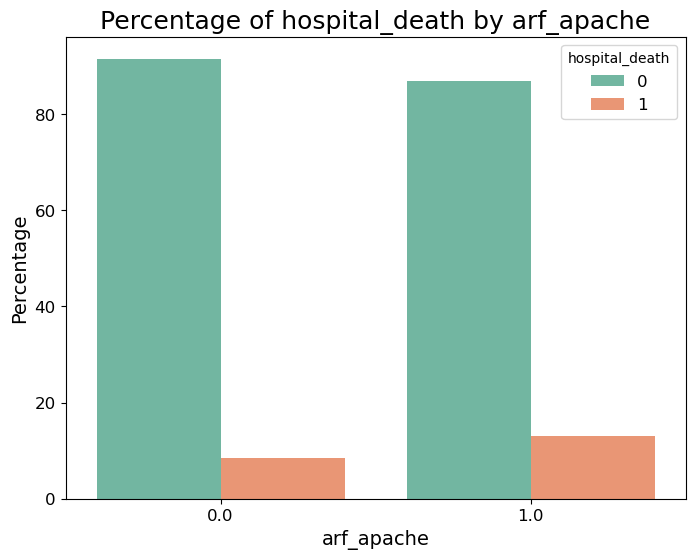

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


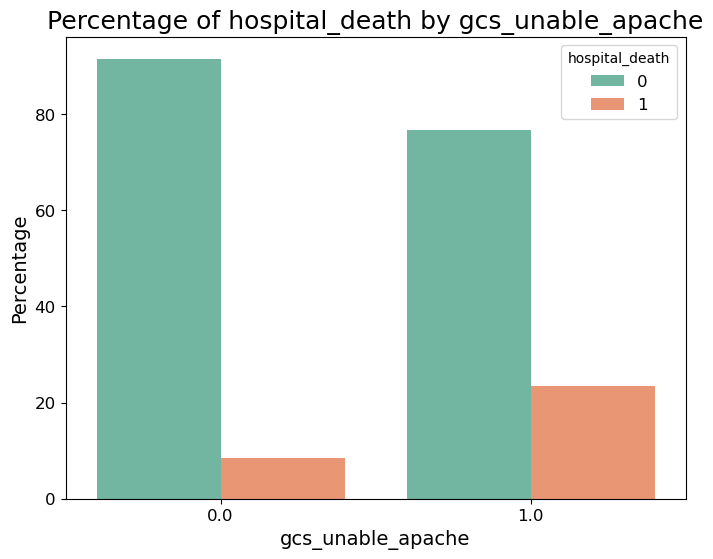

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


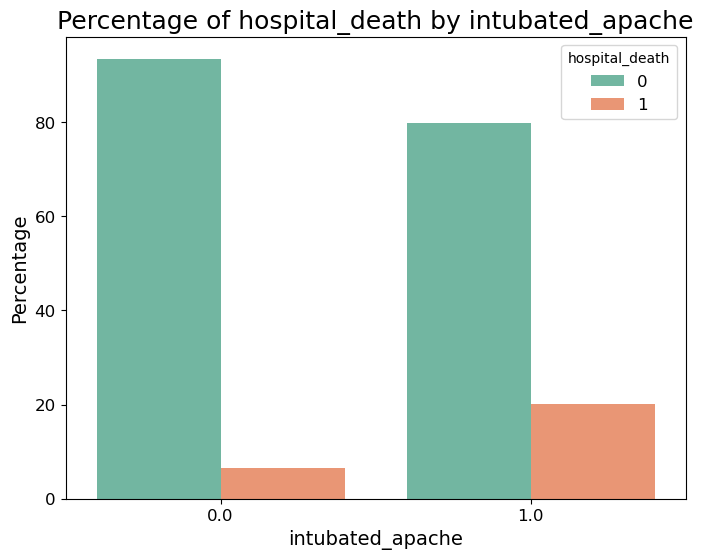

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


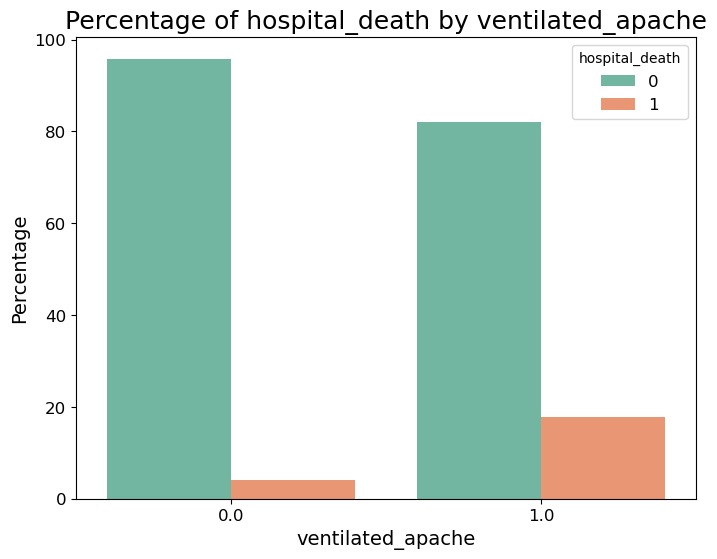

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


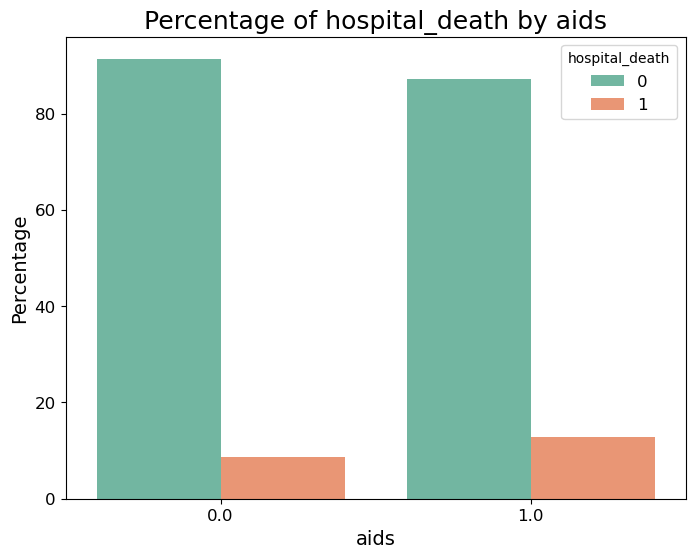

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


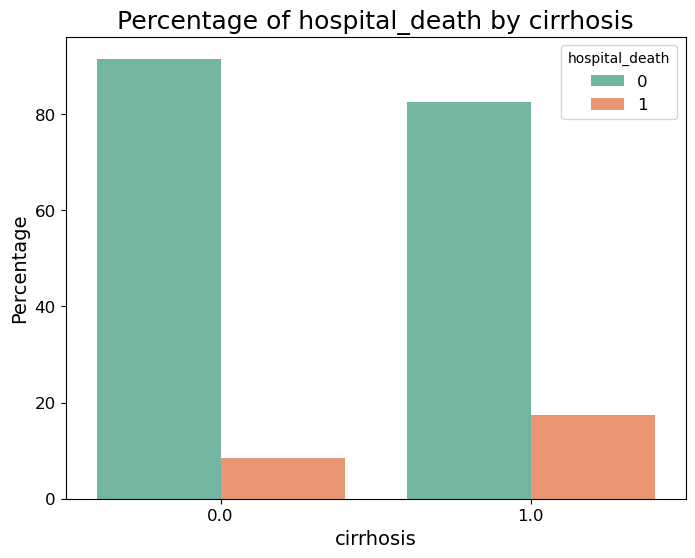

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


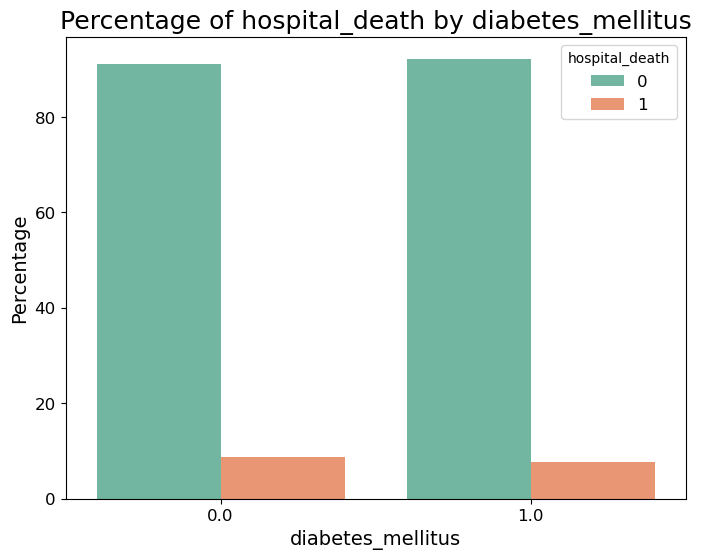

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


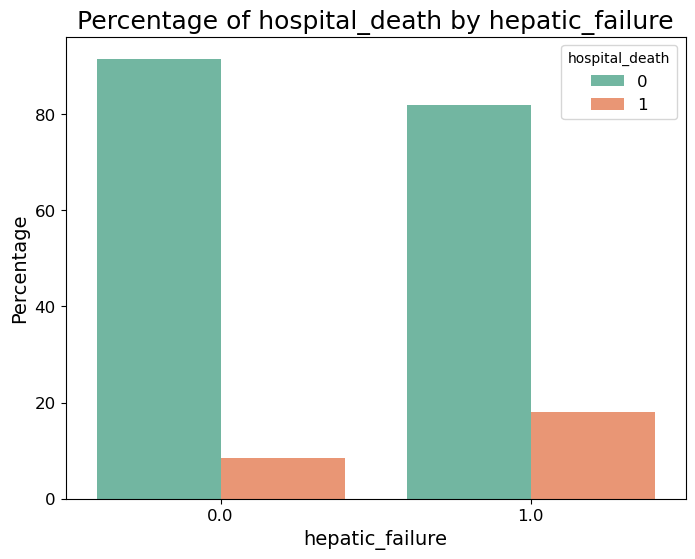

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


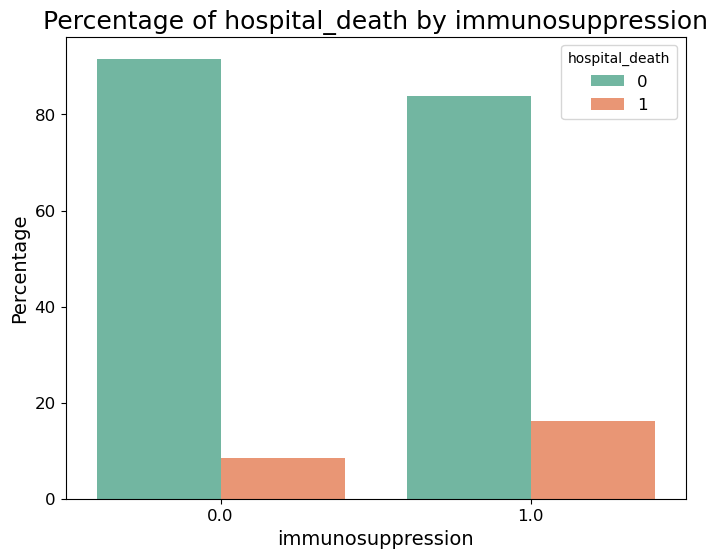

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


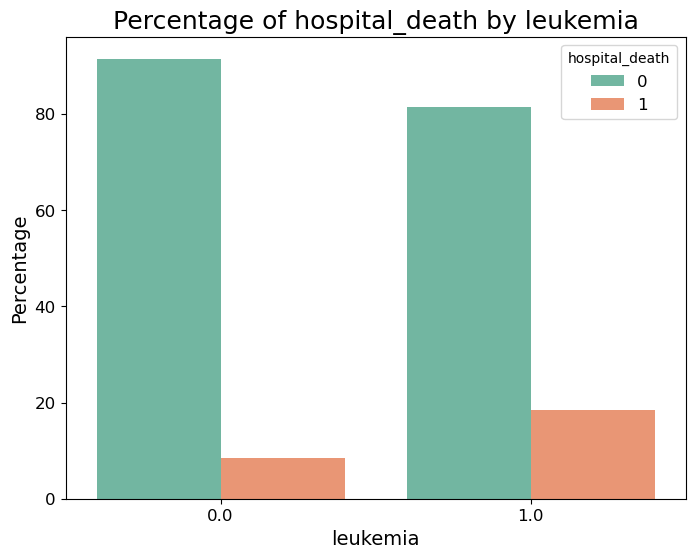

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


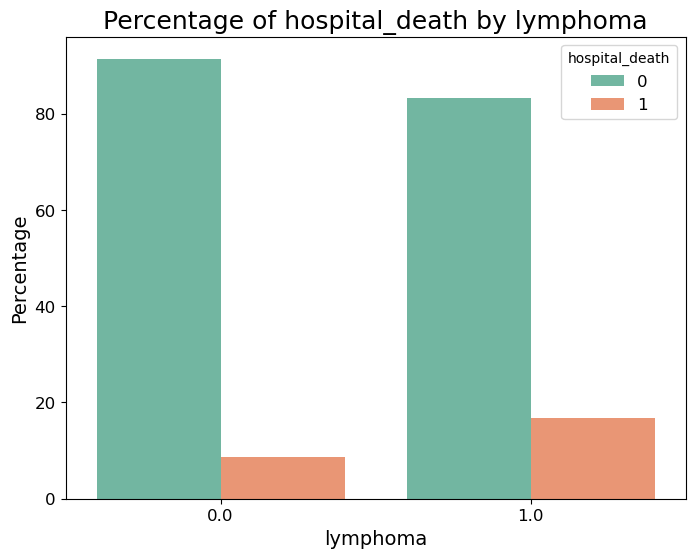

/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_44638/1720820532.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation


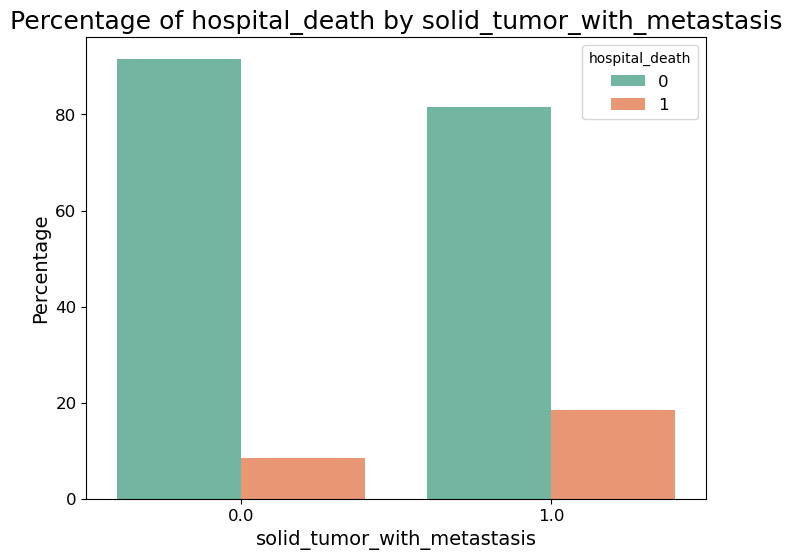

In [22]:
categorical_cols = ['elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_post_operative', 
               'arf_apache','gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
                'diabetes_mellitus','hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']

# Plot bar graphs for each categorical variable
for var in categorical_cols:
    plt.figure(figsize=(8, 6))  # Set the size of the plot area
    
    # Calculate percentage of hospital_death for each category
    counts = Survival.groupby(var)['hospital_death'].value_counts(normalize=True).mul(100)
    counts = counts.rename('percentage').reset_index()

    sns.barplot(data=counts, x=var, y='percentage', hue='hospital_death', palette='Set2', ci=None)  # Plot the bar graph with color differentiation
    plt.title('Percentage of hospital_death by {}'.format(var), fontsize=18)  # Set the title with increased font size
    plt.xlabel(var, fontsize=14)  # Set the x-axis label with increased font size
    plt.ylabel('Percentage', fontsize=14)  # Set the y-axis label with increased font size
    plt.legend(title='hospital_death', loc='upper right', fontsize=12)  # Add legend with increased font size
    plt.xticks(fontsize=12)  # Increase font size of x-axis ticks
    plt.yticks(fontsize=12)  # Increase font size of y-axis ticks
    plt.show()  # Show the bar graph


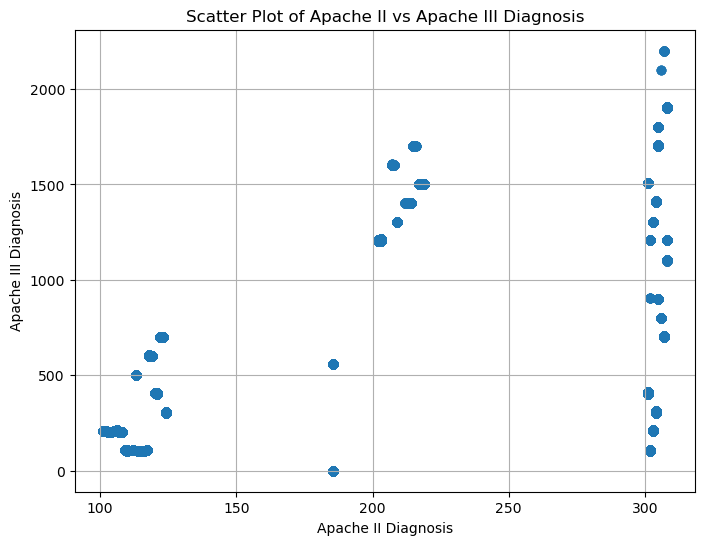

Correlation between Apache II and Apache III diagnoses: 0.39132974553118477


In [23]:
# Apache II　vs Apache III
plt.figure(figsize=(8, 6))
plt.scatter(Survival['apache_2_diagnosis'], Survival['apache_3j_diagnosis'], alpha=0.5)
plt.title('Scatter Plot of Apache II vs Apache III Diagnosis')
plt.xlabel('Apache II Diagnosis')
plt.ylabel('Apache III Diagnosis')
plt.grid(True)
plt.show()

correlation = Survival['apache_2_diagnosis'].corr(Survival['apache_3j_diagnosis'])
print("Correlation between Apache II and Apache III diagnoses:", correlation)

Apache II and Apache II do not necessarily show collinearity based on scatter plots and correlation values.　However, the scoring of these apache_2_diagnosis and apache_3j_diagnosi were not used as predictors in this study because the scoring of these apache_2_diagnosis and apache_3j_diagnosi is different from that usually used (the commonly used Apache II has a maximum of 71, and Apache III has a minimum of 0 and a maximum of 299).

## Variable selection

In [24]:
# Variavle Selection form EDA abd privious knowledge
continuous_cols_interest  = ['age', 'bmi', 'pre_icu_los_days', 'gcs_eyes_apache', 'gcs_motor_apache',
                   'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache']
categorical_cols_interest = ['elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_post_operative', 
               'arf_apache','gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
                'diabetes_mellitus','hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'hospital_death']

In [25]:
Survival_select = Survival[continuous_cols_interest + categorical_cols_interest]
Survival_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   age                          91713 non-null  float64 
 1   bmi                          91713 non-null  float64 
 2   pre_icu_los_days             91713 non-null  float64 
 3   gcs_eyes_apache              91713 non-null  float64 
 4   gcs_motor_apache             91713 non-null  float64 
 5   gcs_verbal_apache            91713 non-null  float64 
 6   heart_rate_apache            91713 non-null  float64 
 7   map_apache                   91713 non-null  float64 
 8   resprate_apache              91713 non-null  float64 
 9   temp_apache                  91713 non-null  float64 
 10  elective_surgery             91713 non-null  category
 11  ethnicity                    90318 non-null  category
 12  gender                       91688 non-null  category
 13  i

In [26]:
# Exlude rows with missing value
Survival_complete =  Survival_select.dropna()

In [27]:
Survival_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89195 entries, 0 to 91712
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   age                          89195 non-null  float64 
 1   bmi                          89195 non-null  float64 
 2   pre_icu_los_days             89195 non-null  float64 
 3   gcs_eyes_apache              89195 non-null  float64 
 4   gcs_motor_apache             89195 non-null  float64 
 5   gcs_verbal_apache            89195 non-null  float64 
 6   heart_rate_apache            89195 non-null  float64 
 7   map_apache                   89195 non-null  float64 
 8   resprate_apache              89195 non-null  float64 
 9   temp_apache                  89195 non-null  float64 
 10  elective_surgery             89195 non-null  category
 11  ethnicity                    89195 non-null  category
 12  gender                       89195 non-null  category
 13  i

In [28]:
y = Survival_complete['hospital_death']
X = Survival_complete.drop(columns=['hospital_death'])
X = pd.get_dummies(X)					

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89195 entries, 0 to 91712
Data columns (total 62 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         89195 non-null  float64
 1   bmi                                         89195 non-null  float64
 2   pre_icu_los_days                            89195 non-null  float64
 3   gcs_eyes_apache                             89195 non-null  float64
 4   gcs_motor_apache                            89195 non-null  float64
 5   gcs_verbal_apache                           89195 non-null  float64
 6   heart_rate_apache                           89195 non-null  float64
 7   map_apache                                  89195 non-null  float64
 8   resprate_apache                             89195 non-null  float64
 9   temp_apache                                 89195 non-null  float64
 10  elective_s

In [30]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [31]:
# Extract column names
column_names = X_train.columns

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames
X_train = pd.DataFrame(X_train_scaled, columns=column_names)
X_test = pd.DataFrame(X_test_scaled, columns=column_names)

# Logitstic Regression

In [1132]:
# Logitstic Regression
# Define and train the logistic regression model
model_log = LogisticRegression(max_iter=1000) 
model_log.fit(X_train_scaled, y_train)

# Make predictions using the test data
y_pred = model_log.predict(X_test_scaled)

In [1133]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Logistic Regression] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Logistic Regression] Confusion Matrix:
 [[24231   266]
 [ 1898   364]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9274    0.9891    0.9573     24497
           1     0.5778    0.1609    0.2517      2262

    accuracy                         0.9191     26759
   macro avg     0.7526    0.5750    0.6045     26759
weighted avg     0.8978    0.9191    0.8976     26759

Matthew's Correlation Coefficient: 0.27532085817855995


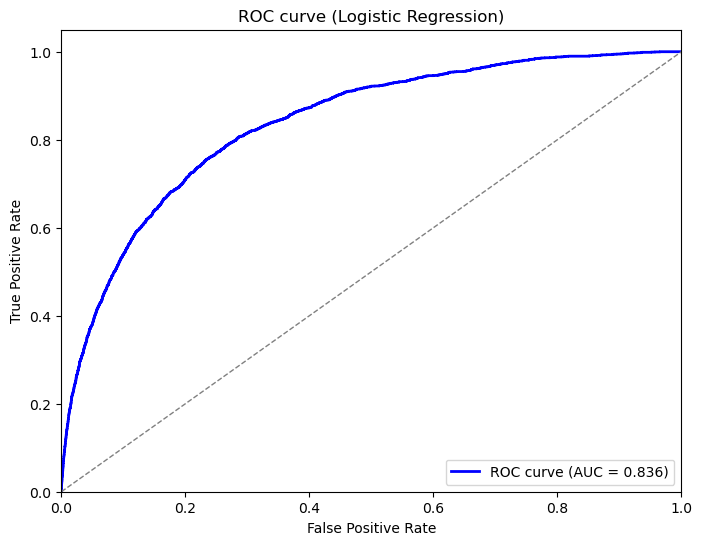

In [1134]:
# Make predictions using the test data
y_pred_proba = model_log.predict_proba(X_test_scaled)[:, 1]  # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds= roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

#### Threshold = 0.2

In [1135]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Logistic Regression (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Logistic Regression (Threshold = 0.2)] Confusion Matrix:
 [[22545  1952]
 [ 1169  1093]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9507    0.9203    0.9353     24497
           1     0.3589    0.4832    0.4119      2262

    accuracy                         0.8834     26759
   macro avg     0.6548    0.7018    0.6736     26759
weighted avg     0.9007    0.8834    0.8910     26759

Matthew's Correlation Coefficient: 0.35348342042455283


## Random Forests

In [1129]:
model_rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=123) 
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=123)

In [1130]:
# Define the range of values for n_estimators to search
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300]}  

# Create the grid search object
grid_search = GridSearchCV(RandomForestRegressor(max_features="sqrt", random_state=123), param_grid, cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Random Forest] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)


Best hyperparameters: {'n_estimators': 300}
[Random Forest] Confusion Matrix:
 [[24323   174]
 [ 1920   342]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9268    0.9929    0.9587     24497
           1     0.6628    0.1512    0.2462      2262

    accuracy                         0.9217     26759
   macro avg     0.7948    0.5720    0.6025     26759
weighted avg     0.9045    0.9217    0.8985     26759

Matthew's Correlation Coefficient: 0.2914789403776631


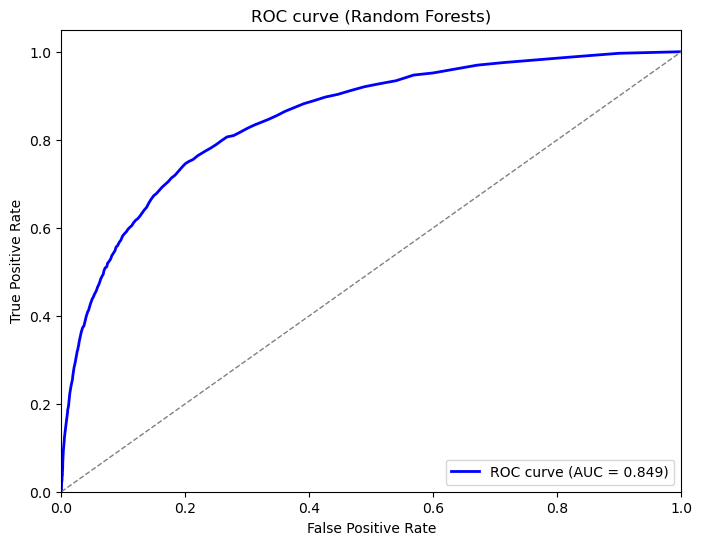

In [1131]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Random Forests)')
plt.legend(loc='lower right')
plt.show()

#### Threshold = 0.2

In [82]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Random Forests (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Random Forests (Threshold = 0.2)] Confusion Matrix:
 [[22149  2348]
 [  969  1293]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9581    0.9042    0.9303     24497
           1     0.3551    0.5716    0.4381      2262

    accuracy                         0.8760     26759
   macro avg     0.6566    0.7379    0.6842     26759
weighted avg     0.9071    0.8760    0.8887     26759

Matthew's Correlation Coefficient: 0.38602367396543524


## Boosting

In [1120]:
# Boosting
model_boosting = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=123) 
model_boosting.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000,
                          random_state=123)

In [1121]:
# Get feature importances from the trained boosting model
feature_importances = model_boosting.feature_importances_

# Create a DataFrame to store feature importances along with feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important predictors
print(importance_df.head(15)) # Get feature importances from the trained boosting model
feature_importances = model_boosting.feature_importances_

                                       Feature  Importance
4                             gcs_motor_apache    0.200792
9                                  temp_apache    0.122839
7                                   map_apache    0.116417
3                              gcs_eyes_apache    0.090864
0                                          age    0.088011
6                            heart_rate_apache    0.082294
44                       ventilated_apache_0.0    0.053024
45                       ventilated_apache_1.0    0.041627
22  icu_admit_source_Operating Room / Recovery    0.037904
8                              resprate_apache    0.027156
11                          elective_surgery_1    0.024006
10                          elective_surgery_0    0.023698
2                             pre_icu_los_days    0.017566
5                            gcs_verbal_apache    0.015662
1                                          bmi    0.011682


In [1122]:
y_pred_proba = model_boosting.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Boosting] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Boosting] Confusion Matrix:
 [[24363   134]
 [ 1950   312]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9259    0.9945    0.9590     24497
           1     0.6996    0.1379    0.2304      2262

    accuracy                         0.9221     26759
   macro avg     0.8127    0.5662    0.5947     26759
weighted avg     0.9068    0.9221    0.8974     26759

Matthew's Correlation Coefficient: 0.2878313488445194


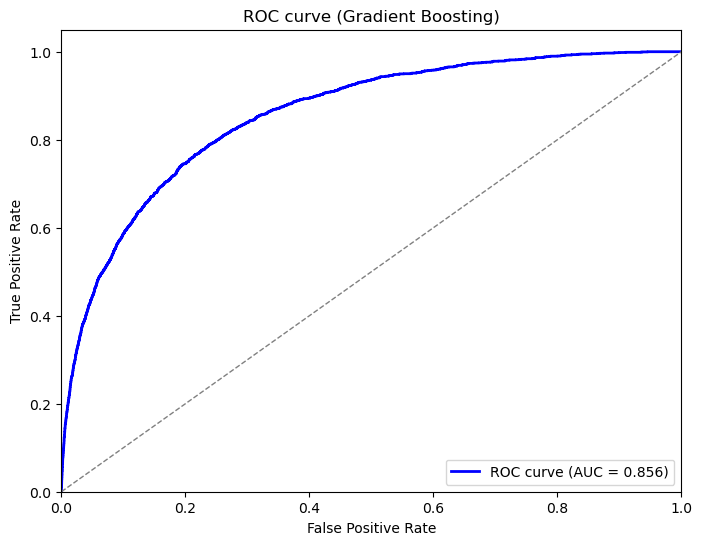

In [1123]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Gradient Boosting)')
plt.legend(loc='lower right')
plt.show()

In [1124]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Gradient Boosting (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Gradient Boosting (Threshold = 0.2)] Confusion Matrix:
 [[22461  2036]
 [ 1037  1225]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9559    0.9169    0.9360     24497
           1     0.3757    0.5416    0.4436      2262

    accuracy                         0.8852     26759
   macro avg     0.6658    0.7292    0.6898     26759
weighted avg     0.9068    0.8852    0.8944     26759

Matthew's Correlation Coefficient: 0.38985052771954914


## Light GBM

In [ ]:
# # Define the LightGBM model
# model_lightgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=123)

# # Fit the model to the training data
# model_lightgbm.fit(X_train, y_train)

NameError: name 'lgb' is not defined

## GAM

In [1125]:
# Define and train the logistic regression model
model_gam = LogisticGAM().fit(X_train, y_train)

# Make predictions using the test data
y_pred = model_gam.predict(X_test)

In [1126]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[GAM] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[GAM] Confusion Matrix:
 [[24209   288]
 [ 1794   468]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9310    0.9882    0.9588     24497
           1     0.6190    0.2069    0.3101      2262

    accuracy                         0.9222     26759
   macro avg     0.7750    0.5976    0.6345     26759
weighted avg     0.9046    0.9222    0.9039     26759

Matthew's Correlation Coefficient: 0.32762455856608996


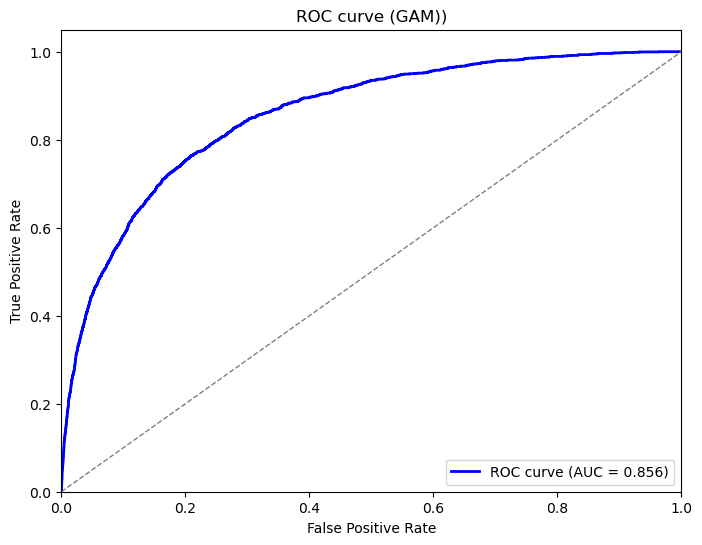

In [1127]:
# Make predictions using the test data
y_pred_proba = model_gam.predict_proba(X_test)  # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (GAM))')
plt.legend(loc='lower right')
plt.show()

In [1128]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[GAM (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[GAM (Threshold = 0.2)] Confusion Matrix:
 [[22570  1927]
 [ 1067  1195]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9549    0.9213    0.9378     24497
           1     0.3828    0.5283    0.4439      2262

    accuracy                         0.8881     26759
   macro avg     0.6688    0.7248    0.6909     26759
weighted avg     0.9065    0.8881    0.8960     26759

Matthew's Correlation Coefficient: 0.3896244729645378


## Supprt Vector Machines

In [195]:
# Define the range of values for C (regularization parameter)
param_grid = {'C': [0.1, 1, 10]} 

# When C is small, we seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which mar have low bias but high variance.

# Create the grid search object
grid_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=123), param_grid, cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 1}


In [196]:
# Use the best hyperparameters to create the final model
model_svm = grid_search.best_estimator_
y_pred = model_svm.predict(X_test)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

Confusion Matrix:
 [[24392   105]
 [ 2083   179]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9213    0.9957    0.9571     24497
           1     0.6303    0.0791    0.1406      2262

    accuracy                         0.9182     26759
   macro avg     0.7758    0.5374    0.5488     26759
weighted avg     0.8967    0.9182    0.8881     26759

Matthew's Correlation Coefficient: 0.20318964304844425


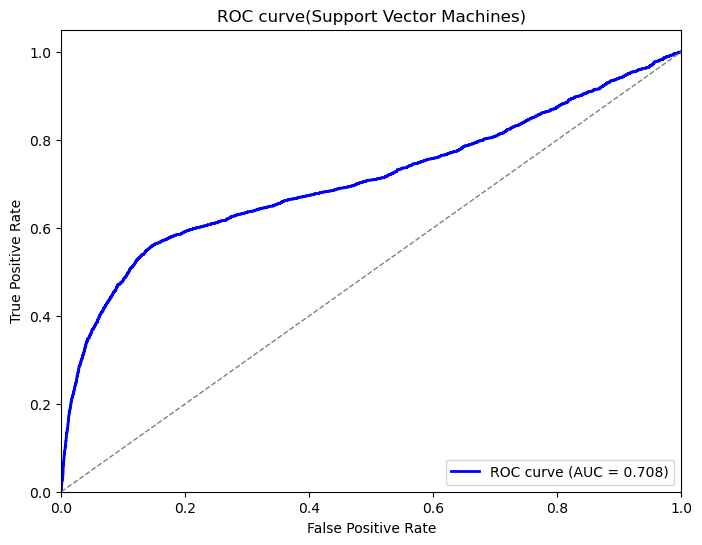

In [197]:
# Make predictions using the test data
y_pred_proba = model_svm.predict_proba(X_test)[:, 1]    # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(Support Vector Machines)')
plt.legend(loc='lower right')
plt.show()

## Deep Learning

In [32]:
# Split the data into training and test sets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X.to_numpy(), 
                                                    y.to_numpy(), 
                                                    test_size=0.30, 
                                                    random_state=123)

In [33]:
# scaling
X_train_dl = scaler.fit_transform(X_train_dl)
X_test_dl = scaler.fit_transform(X_test_dl)

In [34]:
# Create a dataset class called WisconsinDataset
class SurvivalDataset(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32
    self.X = torch.from_numpy(X_train.astype(np.float32))
    # Convert int64 to float32 and apply the
    # unsqueeze function to create an output vector with consistent dimensions .unsqueeze(1): adds an additional dimension (of size 1) to the tensor
    self.y = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
    self.len = self.X.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [35]:
# Instantiate the training data 
traindata = SurvivalDataset(X_train_dl, y_train_dl)

print(traindata[0])
print(len(traindata))

(tensor([ 0.2846, -0.2017, -0.2570,  0.5655,  0.4120,  0.6483,  0.1351,  1.0698,
         0.7352,  0.7164,  0.4760, -0.4760, -0.3453, -0.1132,  0.5269, -0.2085,
        -0.0924, -0.2245, -0.9248,  0.9248,  0.8301, -0.4543, -0.5063, -0.1636,
        -0.0828, -3.9854, -0.0790,  4.2258, -0.2934, -0.2300, -0.2138, -0.2341,
        -0.3035,  0.9055, -0.3023, -0.2465,  0.5032, -0.5032,  0.1686, -0.1686,
         0.0979, -0.0979,  0.4205, -0.4205,  0.6964, -0.6964,  0.0300, -0.0300,
         0.1239, -0.1239, -1.8435,  1.8435,  0.1137, -0.1137,  0.1645, -0.1645,
         0.0860, -0.0860,  0.0647, -0.0647,  0.1457, -0.1457]), tensor([0.]))
62436


### Shallow Networks

#### Hyper Paramater Tuning

In [216]:
# Hyperpatamter Tuning (Dimensionality of Hidden layer, Dropout proportion,　Batch_size, Epoch )
# Define the Neural Network class
class ShallowNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, output_dim, dropout_prob):
        super(ShallowNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.linear2(x))
        return x

# Define training function
def train_model(trainloader, model, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        for inputs, targets in trainloader:
            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            targets = targets.unsqueeze(1)  # Add a dimension to the target tensor
            loss = loss_function(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    return model

def cross_validation(X, y, n_splits, model, loss_function, optimizer, batch_size, epochs):
    kf = KFold(n_splits=n_splits, shuffle=True)
    weighted_accuracies = []  # List to hold accuracy * sample size for each fold
    total_samples = len(X)  # Total number of samples in the entire dataset
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        train_data = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        trainloader = torch.utils.data.DataLoader(train_data, batch_size=256)
        
        model = train_model(trainloader, model, loss_function, optimizer, epochs)
        
        val_data = torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
        valloader = torch.utils.data.DataLoader(val_data, batch_size=256)
        
        correct, total = 0, 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, targets in valloader:
                if len(targets) == 0:  # Skip batches with empty targets
                    continue
                outputs = model(inputs)
                predicted_probs = torch.sigmoid(outputs)
                predicted = (predicted_probs > 0.5).float()
                total += targets.size(0)
                correct += (predicted == targets.unsqueeze(1)).sum().item() 
        
        if total == 0:
            accuracy = 0  # Set accuracy to 0 if no samples are evaluated
        else:
            accuracy = correct / total  # Compute accuracy
        
        # Calculate the sample size of the validation set
        val_sample_size = len(val_index)
        # Append accuracy multiplied by the sample size to the list
        weighted_accuracies.append(accuracy * val_sample_size)
    
    # Calculate the sum of weighted accuracies for all folds
    weighted_sum = sum(weighted_accuracies)
    # Take the average of weighted accuracies by dividing the sum by the total number of samples
    avg_accuracy = weighted_sum / total_samples
    
    return avg_accuracy

# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]

# Set the number of classes
output_dim = 1

# Instantiate the Neural Network class
clf = ShallowNetwork(input_dim, hidden_layer_dim1, output_dim, dropout_prob)

# Instantiate the loss function
weight = torch.tensor([12])  # Weight more on the positive outcome
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimizer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)


# Define hyperparameters to tune
param_grid = {
    'hidden_layer_dim1': [16, 32, 64 ],
    'dropout_prob': [0.3, 0.5, 0.7],
    'batch_size': [32, 64, 128],
    'epochs': [20, 50, 100] 
}

best_accuracy = 0
best_params = {}

# Perform grid search
for hidden_layer_dim1 in param_grid['hidden_layer_dim1']:
    for dropout_prob in param_grid['dropout_prob']:
             for batch_size in param_grid['batch_size']:
                 for epochs in param_grid['epochs']:
                     clf = ShallowNetwork(input_dim, hidden_layer_dim1, output_dim, dropout_prob)
                     avg_accuracy = cross_validation(X_train_dl, y_train_dl, 5, clf, loss_function, optimizer, batch_size, epochs)
                     if avg_accuracy > best_accuracy:
                        best_accuracy = avg_accuracy
                        best_params['hidden_layer_dim1'] = hidden_layer_dim1
                        best_params['dropout_prob'] = dropout_prob
                        best_params['batch_size'] = batch_size
                        best_params['epochs'] = epochs

print("Best hyperparameters:", best_params)
print("Best average accuracy:", best_accuracy)


Best hyperparameters: {'hidden_layer_dim1': 16, 'dropout_prob': 0.3, 'batch_size': 32, 'epochs': 20}
Best average accuracy: 0.08658466269459927


In [217]:
# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]

# Set the number of hidden layers
hidden_layer_dim1 = 16

# Set the number of classes
output_dim = 1

# Set the dropput prob
dropout_prob = 0.3

In [220]:
# Define the Neural Network class
class ShallowNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1,output_dim, dropout_prob):
        super(ShallowNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.linear2(x))
        return x
    
# Set a random seed for reproducibility
torch.manual_seed(123);

# Instantiate the Neural Network class. We have to repeat everytime when run new code
clf = ShallowNetwork(input_dim, hidden_layer_dim1, output_dim, dropout_prob)

# Print out details about the layers of the model
print(clf.parameters)

<bound method Module.parameters of ShallowNetwork(
  (linear1): Linear(in_features=62, out_features=16, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
)>


In [221]:
# Instantiate the dataloader object
batch_size = 32
trainloader = DataLoader(traindata, batch_size=batch_size)

weight = torch.tensor([12]) # weight more on the positive outcome　Selecting the inverse of the proportion of overall deaths as weight
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimzer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)

# Set the number of epochs
epochs = 20

# These variables are used to compute the training accuracy
correct, total = 0, 0

# Define empty list variables that store the losses and accuracies at each epoch
losses = []
accuracies = []

# Loop over the number of epochs
for epoch in range(epochs):
    # Iterate over the minibatches in the trainloader
    for data in trainloader:
        # Get the input and target values in the minibatch
        inputs, targets = data
        # Forward propagation step
        outputs = clf(inputs)
        # Compute the loss
        loss = loss_function(outputs, targets)
        # Compute prediction, anything greater than 0.5 is rounded up to 1, less than 0.5 rounded down to 0
        predicted = torch.round(outputs.data)
        ## round values to the nearest integer, converts the continuous predictions into binary class labels (0 or 1).
        total += targets.size(0)
        ## incremented by the number of samples in the current batch.
        correct += (predicted == targets).sum().item()
        ## calculates the number of correct predictions in the current batch and updates the total count of correct predictions. 
       
        # Zero out previous epoch gradients
        optimizer.zero_grad() 
        # Backward propagation
        loss.backward() 
        # Update model parameters 
        optimizer.step()
    # Compute accuracy    
    acc = correct / total
    
    losses.append(loss.item())
    accuracies.append(acc)
    print("epoch {}  loss : {:.5f}  accuracy : {:.5f}".format(epoch, loss, acc))

epoch 0  loss : 1.99733  accuracy : 0.78975
epoch 1  loss : 1.58381  accuracy : 0.79473
epoch 2  loss : 1.59709  accuracy : 0.79846
epoch 3  loss : 1.60963  accuracy : 0.80070
epoch 4  loss : 1.55288  accuracy : 0.80187
epoch 5  loss : 1.53366  accuracy : 0.80294
epoch 6  loss : 1.61358  accuracy : 0.80432
epoch 7  loss : 1.54086  accuracy : 0.80478
epoch 8  loss : 1.67019  accuracy : 0.80554
epoch 9  loss : 1.51825  accuracy : 0.80631
epoch 10  loss : 1.97306  accuracy : 0.80664
epoch 11  loss : 1.53356  accuracy : 0.80682
epoch 12  loss : 1.68361  accuracy : 0.80718
epoch 13  loss : 1.52047  accuracy : 0.80755
epoch 14  loss : 1.51447  accuracy : 0.80792
epoch 15  loss : 1.68999  accuracy : 0.80832
epoch 16  loss : 1.49994  accuracy : 0.80859
epoch 17  loss : 1.50874  accuracy : 0.80880
epoch 18  loss : 1.51619  accuracy : 0.80896
epoch 19  loss : 1.55677  accuracy : 0.80907


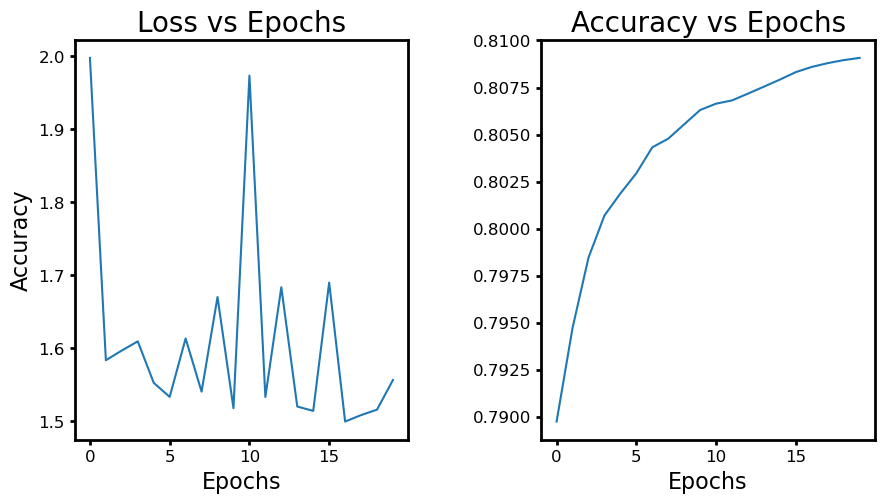

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
# Adjust figure and axes properties
fig.set_size_inches(10, 5)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)
ax1.tick_params(width=2, labelsize=12)
ax2.spines[['top','bottom','left','right']].set_linewidth(2)
ax2.tick_params(width=2, labelsize=12)

# Give the plot title and axis labels
ax1.plot(losses)
ax1.set_title('Loss vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax2.plot(accuracies)
ax2.set_title('Accuracy vs Epochs', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)

# Adjust the subplots to look nice
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# Display the plot
plt.show()

### Test the model (Shallow Networks)

In [223]:
testdata = SurvivalDataset(X_test_dl, y_test_dl)
testloader = DataLoader(testdata, batch_size=batch_size)

correct, total = 0, 0
predicted_labels = []
true_labels = []

# no need to calculate gradients when making predictions
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # calculate output by running through the network
        outputs = clf(inputs)
        # get the predictions
        predicted = torch.round(outputs.data)
        
        # update results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # collect predicted and true labels for evaluation
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Compute accuracy
accuracy = 100 * correct / total

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Compute precision, F1 score, and Matthew coefficient
f1 = f1_score(true_labels, predicted_labels)
matthew = matthews_corrcoef(true_labels, predicted_labels)

print("Matthew Correlation Coefficient: {:.4f}".format(matthew))

Confusion Matrix:
 [[20057  4440]
 [  694  1568]]
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9666    0.8188    0.8865     24497
         1.0     0.2610    0.6932    0.3792      2262

    accuracy                         0.8081     26759
   macro avg     0.6138    0.7560    0.6329     26759
weighted avg     0.9069    0.8081    0.8437     26759

Matthew Correlation Coefficient: 0.3413


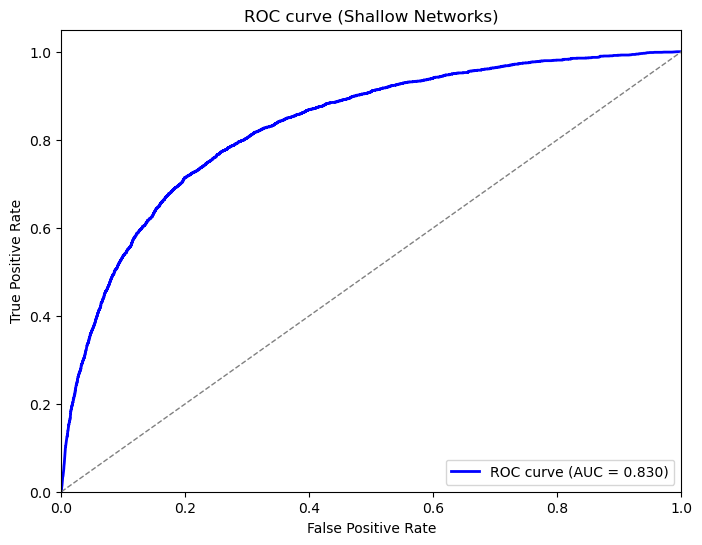

In [224]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Make predictions using the test data
with torch.no_grad():
    outputs = clf(X_test_tensor)
    y_pred_proba = torch.sigmoid(outputs).numpy()  # Convert to probabilities using sigmoid

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Shallow Networks)')
plt.legend(loc='lower right')
plt.show()

### Deep Networks (Hidden Layers = 2)

### Hyper Parametr Tuning

In [228]:
# Hyperpatamter Tuning (dimensionality of Hidden layer, Dropout proportion, Learning rate)
# Define the Neural Network class
class DeepNetwork2(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, hidden_layer_dim2, output_dim, dropout_prob):
        super(DeepNetwork2, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_layer_dim2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.linear3(x))
        return x

# Define training function
def train_model(trainloader, model, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        for inputs, targets in trainloader:
            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            targets = targets.unsqueeze(1)  # Add a dimension to the target tensor
            loss = loss_function(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    return model

def cross_validation(X, y, n_splits, model, loss_function, optimizer, batch_size, epochs):
    kf = KFold(n_splits=n_splits, shuffle=True)
    weighted_accuracies = []  # List to hold accuracy * sample size for each fold
    total_samples = len(X)  # Total number of samples in the entire dataset
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        train_data = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        trainloader = torch.utils.data.DataLoader(train_data, batch_size=256)
        
        model = train_model(trainloader, model, loss_function, optimizer, epochs)
        
        val_data = torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
        valloader = torch.utils.data.DataLoader(val_data, batch_size=256)
        
        correct, total = 0, 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, targets in valloader:
                if len(targets) == 0:  # Skip batches with empty targets
                    continue
                outputs = model(inputs)
                predicted_probs = torch.sigmoid(outputs)
                predicted = (predicted_probs > 0.5).float()
                total += targets.size(0)
                correct += (predicted == targets.unsqueeze(1)).sum().item() 
        
        if total == 0:
            accuracy = 0  # Set accuracy to 0 if no samples are evaluated
        else:
            accuracy = correct / total  # Compute accuracy
        
        # Calculate the sample size of the validation set
        val_sample_size = len(val_index)
        # Append accuracy multiplied by the sample size to the list
        weighted_accuracies.append(accuracy * val_sample_size)
    
    # Calculate the sum of weighted accuracies for all folds
    weighted_sum = sum(weighted_accuracies)
    # Take the average of weighted accuracies by dividing the sum by the total number of samples
    avg_accuracy = weighted_sum / total_samples
    
    return avg_accuracy

# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]


# Set the number of classes
output_dim = 1


# Instantiate the Neural Network class
clf = DeepNetwork2(input_dim, hidden_layer_dim1, hidden_layer_dim2, output_dim, dropout_prob)

# Instantiate the loss function
weight = torch.tensor([12])  # Weight more on the positive outcome
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimizer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)


# Define hyperparameters to tune
param_grid = {
    'hidden_layer_dim1': [32, 16, 8],
    'hidden_layer_dim2': [16, 8, 4],
    'dropout_prob': [0.3, 0.5],
    'batch_size': [32, 64, 128],
    'epochs': [20, 50, 100],
}

best_accuracy = 0
best_params = {}

# Perform grid search
for hidden_layer_dim1 in param_grid['hidden_layer_dim1']:
    for hidden_layer_dim2 in param_grid['hidden_layer_dim2']:
        for dropout_prob in param_grid['dropout_prob']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    clf = DeepNetwork2(input_dim, hidden_layer_dim1, hidden_layer_dim2, output_dim, dropout_prob)
                    avg_accuracy = cross_validation(X_train_dl, y_train_dl, 5, clf, loss_function, optimizer, batch_size, epochs)
                    if avg_accuracy > best_accuracy:
                        best_accuracy = avg_accuracy
                        best_params['hidden_layer_dim1'] = hidden_layer_dim1
                        best_params['hidden_layer_dim2'] = hidden_layer_dim2
                        best_params['dropout_prob'] = dropout_prob
                        best_params['batch_size'] = batch_size
                        best_params['epochs'] = epochs


print("Best hyperparameters:", best_params)
print("Best average accuracy:", best_accuracy)

Best hyperparameters: {'hidden_layer_dim1': 32, 'hidden_layer_dim2': 16, 'dropout_prob': 0.3, 'batch_size': 32, 'epochs': 20}
Best average accuracy: 0.08658466269459927


In [229]:
# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]

# Set the number of hidden layers
hidden_layer_dim1 = 32
hidden_layer_dim2 = 16


# Set the number of classes
output_dim = 1

# Set the dropput prob
dropout_prob = 0.3

In [230]:
# Define the Neural Network class
class DeepNetwork2(torch.nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, hidden_layer_dim2, output_dim, dropout_prob):
        super(DeepNetwork2, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_layer_dim2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.linear3(x))
        return x
    
# Set a random seed for reproducibility
torch.manual_seed(123);

# Instantiate the Neural Network class. We have to repeat everytime when run new code
clf = DeepNetwork2(input_dim, hidden_layer_dim1, hidden_layer_dim2, output_dim, dropout_prob)

# Print out details about the layers of the model
print(clf.parameters)

<bound method Module.parameters of DeepNetwork2(
  (linear1): Linear(in_features=62, out_features=32, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
)>


In [231]:
# Instantiate the dataloader object
batch_size = 32
trainloader = DataLoader(traindata, batch_size=batch_size)
#  The batch size specifies the number of training samples processed by the model in one go.

# Define the loss function
weight = torch.tensor([12]) # weight more on the positive outcome　Selecting the inverse of the proportion of overall deaths as weight
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimzer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)

# Set the number of epochs
epochs = 20

In [232]:
# Define correct and total variables that are initially set to zero
# These variables are used to compute the training accuracy
correct, total = 0, 0

# Define empty list variables that store the losses and accuracies at each epoch
losses = []
accuracies = []

# Loop over the number of epochs
for epoch in range(epochs):
    # Iterate over the minibatches in the trainloader
    for data in trainloader:
        # Get the input and target values in the minibatch
        inputs, targets = data
        # Forward propagation step
        outputs = clf(inputs)
        # Compute the loss
        loss = loss_function(outputs, targets)
        # Compute prediction, anything greater than 0.5 is rounded up to 1, less than 0.5 rounded down to 0
        predicted = torch.round(outputs.data)
        ## round values to the nearest integer, converts the continuous predictions into binary class labels (0 or 1).
        total += targets.size(0)
        ## incremented by the number of samples in the current batch.
        correct += (predicted == targets).sum().item()
        ## calculates the number of correct predictions in the current batch and updates the total count of correct predictions. 
       
        # Zero out previous epoch gradients
        optimizer.zero_grad() 
        # Backward propagation
        loss.backward() 
        # Update model parameters 
        optimizer.step()
    # Compute accuracy    
    acc = correct / total
    
    losses.append(loss.item())
    accuracies.append(acc)
    print("epoch {}  loss : {:.5f}  accuracy : {:.5f}".format(epoch, loss, acc))

epoch 0  loss : 1.82349  accuracy : 0.79340
epoch 1  loss : 1.62431  accuracy : 0.79927
epoch 2  loss : 1.64681  accuracy : 0.80224
epoch 3  loss : 1.49467  accuracy : 0.80357
epoch 4  loss : 1.55445  accuracy : 0.80447
epoch 5  loss : 1.83458  accuracy : 0.80494
epoch 6  loss : 1.59352  accuracy : 0.80588
epoch 7  loss : 1.60937  accuracy : 0.80686
epoch 8  loss : 1.51704  accuracy : 0.80676
epoch 9  loss : 1.50802  accuracy : 0.80737
epoch 10  loss : 1.47651  accuracy : 0.80786
epoch 11  loss : 1.54977  accuracy : 0.80852
epoch 12  loss : 1.48192  accuracy : 0.80889
epoch 13  loss : 1.48653  accuracy : 0.80861
epoch 14  loss : 1.56568  accuracy : 0.80893
epoch 15  loss : 1.89746  accuracy : 0.80913
epoch 16  loss : 1.48575  accuracy : 0.80937
epoch 17  loss : 1.59380  accuracy : 0.80969
epoch 18  loss : 1.55326  accuracy : 0.80978
epoch 19  loss : 1.55823  accuracy : 0.81008


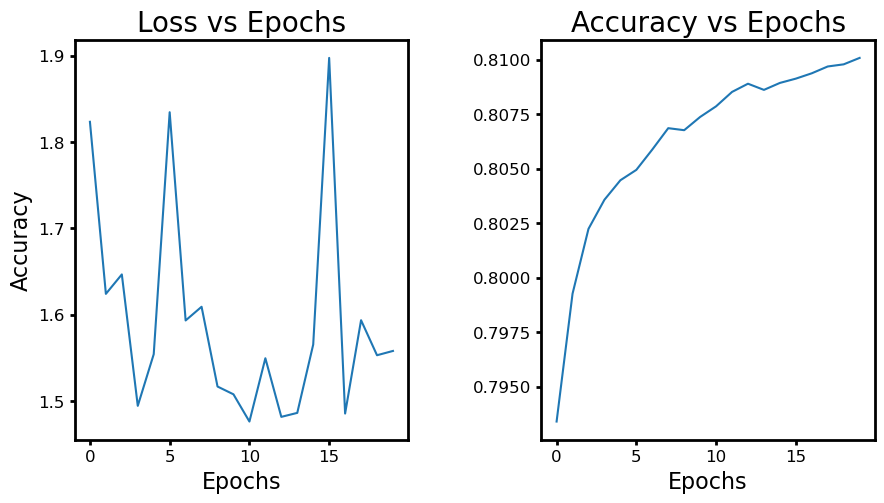

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

# Adjust figure and axes properties
fig.set_size_inches(10, 5)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)
ax1.tick_params(width=2, labelsize=12)
ax2.spines[['top','bottom','left','right']].set_linewidth(2)
ax2.tick_params(width=2, labelsize=12)

# Give the plot title and axis labels
ax1.plot(losses)
ax1.set_title('Loss vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax2.plot(accuracies)
ax2.set_title('Accuracy vs Epochs', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)

# Adjust the subplots to look nice
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# Display the plot
plt.show()

### Test the model (Deep Networks Hidden Layers = 2)

In [235]:
testdata = SurvivalDataset(X_test_dl, y_test_dl)
testloader = DataLoader(testdata, batch_size=batch_size)

correct, total = 0, 0
predicted_labels = []
true_labels = []

# no need to calculate gradients when making predictions
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # calculate output by running through the network
        outputs = clf(inputs)
        # get the predictions
        predicted = torch.round(outputs.data)
        
        # update results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # collect predicted and true labels for evaluation
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Compute accuracy
accuracy = 100 * correct / total

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Compute precision, F1 score, and Matthew coefficient
matthew = matthews_corrcoef(true_labels, predicted_labels)

print("Matthew Correlation Coefficient: {:.4f}".format(matthew))

Confusion Matrix:
 [[20319  4178]
 [  748  1514]]
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9645    0.8294    0.8919     24497
         1.0     0.2660    0.6693    0.3807      2262

    accuracy                         0.8159     26759
   macro avg     0.6152    0.7494    0.6363     26759
weighted avg     0.9054    0.8159    0.8487     26759

Matthew Correlation Coefficient: 0.3391


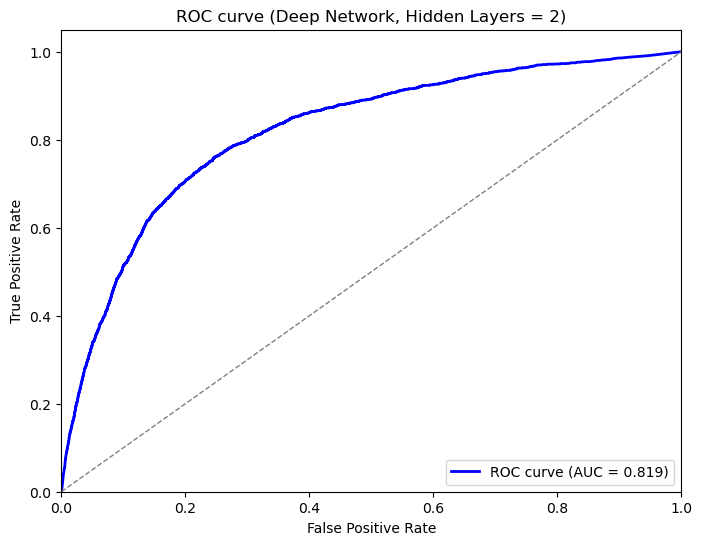

In [236]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Make predictions using the test data
with torch.no_grad():
    outputs = clf(X_test_tensor)
    y_pred_proba = torch.sigmoid(outputs).numpy()  # Convert to probabilities using sigmoid

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Deep Network, Hidden Layers = 2)')
plt.legend(loc='lower right')
plt.show()

### Hyper Parametr Tuning

### Deep Networks (Hidden Layers = 5)

In [309]:
# Hyperpatamter Tuning (Dimensionality of Hidden layer, Dropout proportion, Batch Size, Epochs)
# Define the Neural Network class
class DeepNetwork5(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, hidden_layer_dim4, hidden_layer_dim5, output_dim, dropout_prob):
        super(DeepNetwork5, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_layer_dim2, hidden_layer_dim3)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear4 = nn.Linear(hidden_layer_dim3, hidden_layer_dim4)
        self.dropout4 = nn.Dropout(dropout_prob)
        self.linear5 = nn.Linear(hidden_layer_dim4, hidden_layer_dim5)
        self.dropout5 = nn.Dropout(dropout_prob)
        self.linear6 = nn.Linear(hidden_layer_dim5, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = F.relu(self.linear4(x))
        x = self.dropout4(x)
        x = F.relu(self.linear5(x))
        x = self.dropout5(x)
        x = torch.sigmoid(self.linear6(x))
        return x

# Define training function
def train_model(trainloader, model, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        for inputs, targets in trainloader:
            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            targets = targets.unsqueeze(1)  # Add a dimension to the target tensor
            loss = loss_function(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    return model

def cross_validation(X, y, n_splits, model, loss_function, optimizer, batch_size, epochs):
    kf = KFold(n_splits=n_splits, shuffle=True)
    weighted_accuracies = []  # List to hold accuracy * sample size for each fold
    total_samples = len(X)  # Total number of samples in the entire dataset
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        train_data = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        trainloader = torch.utils.data.DataLoader(train_data, batch_size = 256)
        
        model = train_model(trainloader, model, loss_function, optimizer, epochs)
        
        val_data = torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
        valloader = torch.utils.data.DataLoader(val_data, batch_size=256)
        
        correct, total = 0, 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, targets in valloader:
                if len(targets) == 0:  # Skip batches with empty targets
                    continue
                outputs = model(inputs)
                predicted_probs = torch.sigmoid(outputs)
                predicted = (predicted_probs > 0.5).float()
                total += targets.size(0)
                correct += (predicted == targets.unsqueeze(1)).sum().item() 
        
        if total == 0:
            accuracy = 0  # Set accuracy to 0 if no samples are evaluated
        else:
            accuracy = correct / total  # Compute accuracy
        
        # Calculate the sample size of the validation set
        val_sample_size = len(val_index)
        # Append accuracy multiplied by the sample size to the list
        weighted_accuracies.append(accuracy * val_sample_size)
    
    # Calculate the sum of weighted accuracies for all folds
    weighted_sum = sum(weighted_accuracies)
    # Take the average of weighted accuracies by dividing the sum by the total number of samples
    avg_accuracy = weighted_sum / total_samples
    
    return avg_accuracy

# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]


# Set the number of classes
output_dim = 1


# Instantiate the Neural Network class
clf = DeepNetwork5(input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, hidden_layer_dim4, hidden_layer_dim5, output_dim, dropout_prob)

# Instantiate the loss function
weight = torch.tensor([12])  # Weight more on the positive outcome
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimizer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)


# Define hyperparameters to tune
param_grid = {
    'hidden_layer_dim1': [64, 32],
    'hidden_layer_dim2': [64, 32],
    'hidden_layer_dim3': [32, 16],
    'hidden_layer_dim4': [16, 8],
    'hidden_layer_dim5': [8, 4],
    'dropout_prob': [0.3, 0.5],
    'batch_size': [16, 32],
    'epochs': [5, 10, 15,] 
}

best_accuracy = 0
best_params = {}

# Perform grid search
for hidden_layer_dim1 in param_grid['hidden_layer_dim1']:
    for hidden_layer_dim2 in param_grid['hidden_layer_dim2']:
        for hidden_layer_dim3 in param_grid['hidden_layer_dim3']:
            for hidden_layer_dim4 in param_grid['hidden_layer_dim4']:
                for hidden_layer_dim5 in param_grid['hidden_layer_dim5']:
                    for dropout_prob in param_grid['dropout_prob']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                clf = DeepNetwork5(input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, hidden_layer_dim4, hidden_layer_dim5, output_dim, dropout_prob)
                                avg_accuracy = cross_validation(X_train_dl, y_train_dl, 5, clf, loss_function, optimizer, batch_size, epochs)
                                if avg_accuracy > best_accuracy:
                                    best_accuracy = avg_accuracy
                                    best_params['hidden_layer_dim1'] = hidden_layer_dim1
                                    best_params['hidden_layer_dim2'] = hidden_layer_dim2
                                    best_params['hidden_layer_dim3'] = hidden_layer_dim3
                                    best_params['hidden_layer_dim4'] = hidden_layer_dim4
                                    best_params['hidden_layer_dim5'] = hidden_layer_dim5
                                    best_params['dropout_prob'] = dropout_prob
                                    best_params['batch_size'] = batch_size
                                    best_params['epochs'] = epochs

print("Best hyperparameters:", best_params)
print("Best average accuracy:", best_accuracy)

Best hyperparameters: {'hidden_layer_dim1': 64, 'hidden_layer_dim2': 64, 'hidden_layer_dim3': 32, 'hidden_layer_dim4': 16, 'hidden_layer_dim5': 8, 'dropout_prob': 0.3, 'batch_size': 16, 'epochs': 5}
Best average accuracy: 0.08658466269459927


In [310]:
# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]

# Set the number of hidden layers
hidden_layer_dim1 = 64
hidden_layer_dim2 = 64
hidden_layer_dim3 = 32
hidden_layer_dim4 = 16
hidden_layer_dim5 = 8

# Set the number of classes
output_dim = 1

# Set the dropput prob
dropout_prob = 0.3

In [311]:
# Define the Neural Network class
class DeepNetwork5(torch.nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, hidden_layer_dim4, hidden_layer_dim5, output_dim, dropout_prob):
        super(DeepNetwork5, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_layer_dim2, hidden_layer_dim3)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear4 = nn.Linear(hidden_layer_dim3, hidden_layer_dim4)
        self.dropout4 = nn.Dropout(dropout_prob)
        self.linear5 = nn.Linear(hidden_layer_dim4, hidden_layer_dim5)
        self.dropout5 = nn.Dropout(dropout_prob)
        self.linear6 = nn.Linear(hidden_layer_dim5, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = F.relu(self.linear4(x))
        x = self.dropout4(x)
        x = F.relu(self.linear5(x))
        x = self.dropout5(x)
        x = torch.sigmoid(self.linear6(x))
        return x
    
# Set a random seed for reproducibility
torch.manual_seed(123);

# Instantiate the Neural Network class. We have to repeat everytime when run new code
clf = DeepNetwork5(input_dim, hidden_layer_dim1, hidden_layer_dim2,  hidden_layer_dim3,  hidden_layer_dim4, hidden_layer_dim5, output_dim, dropout_prob)

# Print out details about the layers of the model
print(clf.parameters)

<bound method Module.parameters of DeepNetwork5(
  (linear1): Linear(in_features=62, out_features=64, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
  (dropout5): Dropout(p=0.3, inplace=False)
  (linear6): Linear(in_features=8, out_features=1, bias=True)
)>


In [312]:
# Instantiate the dataloader object
batch_size = 16
trainloader = DataLoader(traindata, batch_size=batch_size)
#  The batch size specifies the number of training samples processed by the model in one go.

# Define the loss function
weight = torch.tensor([12]) # weight more on the positive outcome　Selecting the inverse of the proportion of overall deaths as weight
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

# Set the optimzer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001 , weight_decay=weight_decay)

# Set the number of epochs
epochs = 5

In [313]:
# Define correct and total variables that are initially set to zero
# These variables are used to compute the training accuracy
correct, total = 0, 0

# Define empty list variables that store the losses and accuracies at each epoch
losses = []
accuracies = []

# Loop over the number of epochs
for epoch in range(epochs):
    # Iterate over the minibatches in the trainloader
    for data in trainloader:
        # Get the input and target values in the minibatch
        inputs, targets = data
        # Forward propagation step
        outputs = clf(inputs)
        # Compute the loss
        loss = loss_function(outputs, targets)
        # Compute prediction, anything greater than 0.5 is rounded up to 1, less than 0.5 rounded down to 0
        predicted = torch.round(outputs.data)
        ## round values to the nearest integer, converts the continuous predictions into binary class labels (0 or 1).
        total += targets.size(0)
        ## incremented by the number of samples in the current batch.
        correct += (predicted == targets).sum().item()
        ## calculates the number of correct predictions in the current batch and updates the total count of correct predictions. 
       
        # Zero out previous epoch gradients
        optimizer.zero_grad() 
        # Backward propagation
        loss.backward() 
        # Update model parameters 
        optimizer.step()
    # Compute accuracy    
    acc = correct / total
    
    losses.append(loss.item())
    accuracies.append(acc)
    print("epoch {}  loss : {:.5f}  accuracy : {:.5f}".format(epoch, loss, acc))

epoch 0  loss : 1.69398  accuracy : 0.80620
epoch 1  loss : 2.18231  accuracy : 0.79129
epoch 2  loss : 1.49842  accuracy : 0.78640
epoch 3  loss : 1.81637  accuracy : 0.78445
epoch 4  loss : 1.60264  accuracy : 0.78729


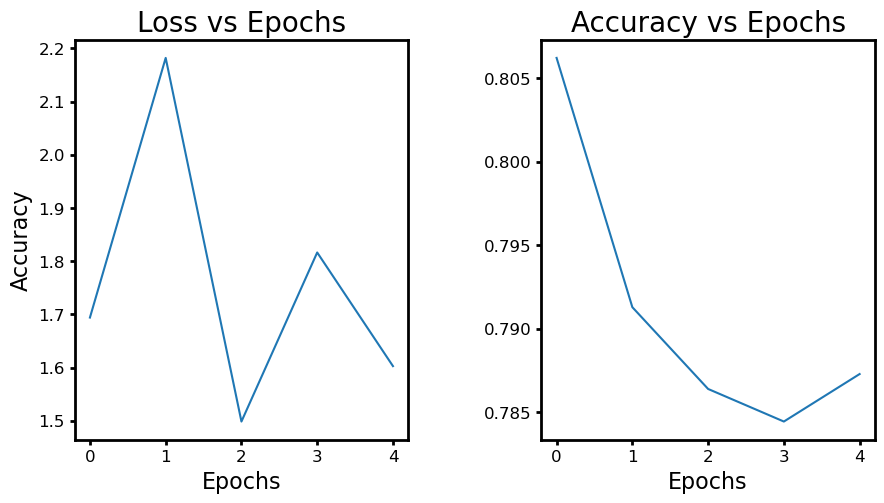

In [314]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

# Adjust figure and axes properties
fig.set_size_inches(10, 5)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)
ax1.tick_params(width=2, labelsize=12)
ax2.spines[['top','bottom','left','right']].set_linewidth(2)
ax2.tick_params(width=2, labelsize=12)

# Give the plot title and axis labels
ax1.plot(losses)
ax1.set_title('Loss vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax2.plot(accuracies)
ax2.set_title('Accuracy vs Epochs', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)

# Adjust the subplots to look nice
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# Display the plot
plt.show()

### Test the model (Deep Networks Hidden Layers = 5)

In [315]:
testdata = SurvivalDataset(X_test_dl, y_test_dl)
testloader = DataLoader(testdata, batch_size=batch_size)

correct, total = 0, 0
predicted_labels = []
true_labels = []

# no need to calculate gradients when making predictions
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # calculate output by running through the network
        outputs = clf(inputs)
        # get the predictions
        predicted = torch.round(outputs.data)
        
        # update results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # collect predicted and true labels for evaluation
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Compute accuracy
accuracy = 100 * correct / total

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Compute precision, F1 score, and Matthew coefficient
f1 = f1_score(true_labels, predicted_labels)
matthew = matthews_corrcoef(true_labels, predicted_labels)

print("Matthew Correlation Coefficient: {:.4f}".format(matthew))

Confusion Matrix:
 [[18033  6464]
 [  564  1698]]
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9697    0.7361    0.8369     24497
         1.0     0.2080    0.7507    0.3258      2262

    accuracy                         0.7374     26759
   macro avg     0.5889    0.7434    0.5814     26759
weighted avg     0.9053    0.7374    0.7937     26759

Matthew Correlation Coefficient: 0.2941


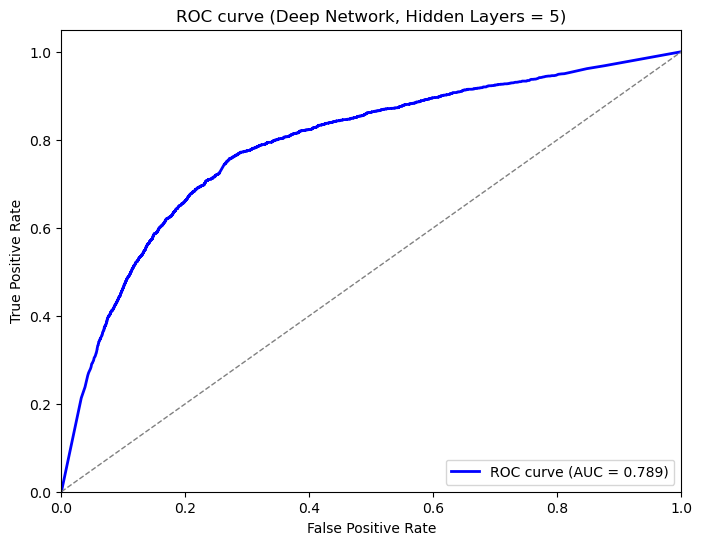

In [316]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Make predictions using the test data
with torch.no_grad():
    outputs = clf(X_test_tensor)
    y_pred_proba = torch.sigmoid(outputs).numpy()  # Convert to probabilities using sigmoid

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (Deep Network, Hidden Layers = 5)')
plt.legend(loc='lower right')
plt.show()